In [1]:
import sys
import os
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from adjoint_esn.esn import ESN
from adjoint_esn.utils import preprocessing as pp
from pathlib import Path
from adjoint_esn.rijke_galerkin.solver import Rijke
from scipy.integrate import odeint
from adjoint_esn.utils import signals as sig

In [2]:
def run_rijke_sim(beta,tau,N_g,t_sim_len,data_dt,data_path=None,u_f_order=1,x_f=0.2):
    my_rijke = Rijke(N_g=N_g,N_c=10,c_1=0.1,c_2=0.06,beta=beta,x_f=x_f,tau=tau,
                     heat_law="kings_poly",damping="modal")
    
    if data_path is None:
        y0 = np.zeros(my_rijke.N_dim+1)
        y0[0] = 1.0
        
        # Temporal grid
        t_sim = np.arange(0, t_sim_len+data_dt, data_dt)

        # Solve ODE using odeint
        y_sim = odeint(my_rijke.ode, y0, t_sim, tfirst=True)
    else:
        data_dict = pp.read_h5(data_path)
        y_sim = data_dict["y"]
        t_sim = data_dict["t"]

    #gal_idx = np.arange(2 * my_rijke.N_g+my_rijke.N_c)
    #gal_idx = gal_idx.tolist()

    gal_idx = np.arange(2 * my_rijke.N_g)
    gal_idx = gal_idx.tolist()
    U_sim = y_sim[:, gal_idx]

    u_f_idx = 2 * my_rijke.N_g+my_rijke.N_c-1
    for order in range(u_f_order):
        U_sim = np.hstack((U_sim, y_sim[:,u_f_idx][:,None]**(order+1)))   

    #u_f_tau_sim = y_sim[:,my_rijke.N_c-1]
    #q_sim = np.zeros((len(u_f_tau_sim),1))
    #for idx,u_f_tau in enumerate(u_f_tau_sim):
    #    if abs(u_f_tau + 1.0) < 0.01:
    #        coeffs = np.array([-1.0, 0.0, 1.75e3, 6.2e-12, -7.5e6])
    #        poly = np.poly1d(coeffs[::-1])
    #        q_sim[idx] = poly(1.0 + u_f_tau)
    #    else:
    #        q_sim[idx] = (np.sqrt(np.abs(1.0 + u_f_tau)) - 1.0)
    #U_sim = np.hstack((y_sim[:, gal_idx],q_sim))
    return y_sim, U_sim, t_sim

def create_dataset(U_sim,t_sim,dt,
                   t_transient_len,
                   t_washout_len,
                   t_train_len,
                   t_val_len,
                   u_f_order=1):
    data_dt=t_sim[1]-t_sim[0]

    # upsample
    upsample = int(np.round(dt/data_dt))
    U = U_sim[::upsample,:]
    t = t_sim[::upsample]

    # cut the transient    
    N_transient = int(np.round(t_transient_len/dt))
    U = U[N_transient:,:]
    t = t[N_transient:]-t[N_transient]

    # separate into washout, train, val
    N_washout = int(np.round(t_washout_len/dt))
    N_train = int(np.round(t_train_len/dt))
    N_val = int(np.round(t_val_len/dt))

    U_washout_train = U[0:N_washout,:]
    U_washout_val = U[N_washout+N_train:2*N_washout+N_train,:]
    U_val = U[2*N_washout+N_train:2*N_washout+N_train+N_val-1,:]

    U_train = U[N_washout:N_washout+N_train-1,:]
    t_train = t[N_washout+1:N_washout+N_train]
    t_val = t[2*N_washout+N_train+1:2*N_washout+N_train+N_val]

    if u_f_order > 0:
        Y_train = U[N_washout+1:N_washout+N_train,:-u_f_order]
        Y_val = U[2*N_washout+N_train+1:2*N_washout+N_train+N_val,:-u_f_order]
    elif u_f_order == 0:
        Y_train = U[N_washout+1:N_washout+N_train,:]
        Y_val = U[2*N_washout+N_train+1:2*N_washout+N_train+N_val,:]

    return U_washout_train, U_train, Y_train, t_train, U_washout_val, U_val, Y_val, t_val

def load_data_sys(beta,tau,N_g,t_sim_len,data_dt,dt,
                   t_transient_len,
                   t_washout_len,
                   t_train_len,
                   t_val_len,data_path=None,u_f_order=1,x_f=0.2):
    _, U_sim, t_sim = run_rijke_sim(beta,tau,N_g,t_sim_len,data_dt,data_path,u_f_order,x_f)
    U_washout_train, U_train, Y_train, t_train, U_washout_val, U_val, Y_val, t_val = create_dataset(U_sim,t_sim,dt,
                   t_transient_len,
                   t_washout_len,
                   t_train_len,
                   t_val_len,u_f_order)
    return U_washout_train, U_train, Y_train, t_train, U_washout_val, U_val, Y_val, t_val


In [13]:
sim_dict = {"t_sim_len": 800,
            "data_dt": 1e-2,
            "dt": 1e-2,
            "t_transient_len": 200,
            "t_washout_len": 4,
            "t_train_len": 200,
            "t_val_len": 200,
            }

param = "both"
# p_list = [1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0]
# p_list = [1.0,2.0,3.0,4.0,5.0]
# p_list = [1.2,1.6,2.0,2.4,2.8]
# p_list = [0.6,0.9,1.2,1.5,1.8]
# p_list = [1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0]
# p_list = [3.0,3.5,4.0]

beta_list = np.array([2.5])
tau_list = np.array([0.05,0.1,0.15,0.2,0.25,0.3])
beta_mesh, tau_mesh = np.meshgrid(beta_list, tau_list)
p_list = np.hstack([beta_mesh.flatten()[:, None], tau_mesh.flatten()[:, None]])

N_g = 4
u_f_order = 3
len_p_list = len(p_list)
U_washout_train = [None]*len_p_list
U_train = [None]*len_p_list
Y_train = [None]*len_p_list
t_train = [None]*len_p_list
U_washout_val = [None]*len_p_list
U_val = [None]*len_p_list
U_val = [None]*len_p_list
Y_val = [None]*len_p_list
t_val = [None]*len_p_list

for p_idx, p in enumerate(p_list):
    if param == "beta":
        beta = p
        print("Beta:", beta)
        tau = 0.2
    elif param == "tau":
        tau = p
        print("Tau:", tau)
        beta = 1.2
    elif param == "both":
        beta = p[0]
        tau= p[1]

    beta_name = f'{beta:.2f}'
    beta_name = beta_name.replace(".","_")
    tau_name = f'{tau:.2f}'
    tau_name = tau_name.replace(".","_")
    data_path = f"data_new/rijke_kings_poly_N_g_4_beta_{beta_name}_tau_{tau_name}.h5"

    (U_washout_train[p_idx], 
     U_train[p_idx], 
     Y_train[p_idx], 
     t_train[p_idx], 
     U_washout_val[p_idx], 
     U_val[p_idx], 
     Y_val[p_idx], 
     t_val[p_idx]) = load_data_sys(beta=beta,tau=tau,N_g=N_g,
                                    **sim_dict,data_path=data_path,u_f_order=u_f_order)
    
    dim = U_train[0].shape[1]
    periods = np.array([sig.period(U_train[p_idx][:,i], sim_dict["dt"]) for i in range(dim)])
    print("Periods: ", periods)
    print("Period steps:", np.round(periods/sim_dict["dt"]))

P_washout_train = [None]*len_p_list
P_train = [None]*len_p_list
P_washout_val = [None]*len_p_list
P_val = [None]*len_p_list
P_mean = np.array(np.mean(p_list))


for p_idx, p in enumerate(p_list):
    if param == "beta":
        beta = p
        print("Beta:", beta)
        tau = 0.2
    elif param == "tau":
        tau = p
        print("Tau:", tau)
        beta = 1.2
    elif param == "both":
        beta = p[0]
        tau= p[1]
    
    P_washout_train[p_idx] = beta*np.ones((len(U_washout_train[p_idx]),1))
    P_train[p_idx] = beta*np.ones((len(U_train[p_idx]),1))
    P_washout_val[p_idx] = beta*np.ones((len(U_washout_val[p_idx]),1))
    P_val[p_idx] = beta*np.ones((len(U_val[p_idx]),1))

scale = [None]*2
scale[0] = np.zeros(dim)
scale[1] = np.ones(dim)

Periods:  [1.8 1.8 1.8 1.8 1.8 1.8 1.8 1.8 1.8 1.8 1.8]
Period steps: [180. 180. 180. 180. 180. 180. 180. 180. 180. 180. 180.]
Periods:  [1.9 1.9 1.9 1.9 1.9 1.9 1.9 1.9 1.9 1.9 1.9]
Period steps: [190. 190. 190. 190. 190. 190. 190. 190. 190. 190. 190.]
Periods:  [1.93 1.93 1.93 1.93 1.93 1.93 1.93 1.93 1.93 1.93 1.93]
Period steps: [193. 193. 193. 193. 193. 193. 193. 193. 193. 193. 193.]
Periods:  [1.96 1.96 1.96 1.96 1.96 1.96 1.96 1.96 1.96 1.96 1.96]
Period steps: [196. 196. 196. 196. 196. 196. 196. 196. 196. 196. 196.]
Periods:  [1.98 1.98 1.98 1.98 1.98 1.98 1.98 1.98 1.98 1.98 1.98]
Period steps: [198. 198. 198. 198. 198. 198. 198. 198. 198. 198. 198.]
Periods:  [1.99 1.99 1.99 1.99 1.99 1.99 1.99 1.99 1.99 1.99 1.99]
Period steps: [199. 199. 199. 199. 199. 199. 199. 199. 199. 199. 199.]


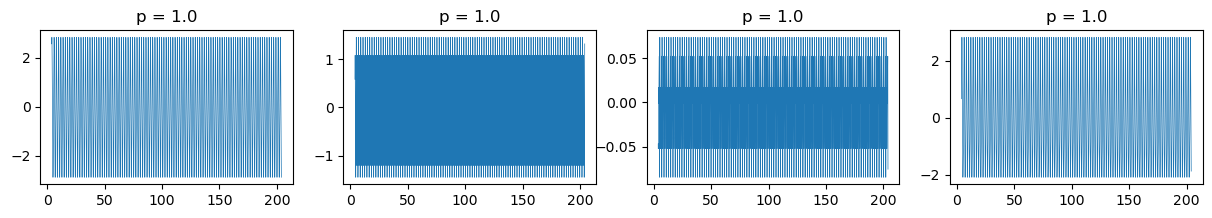

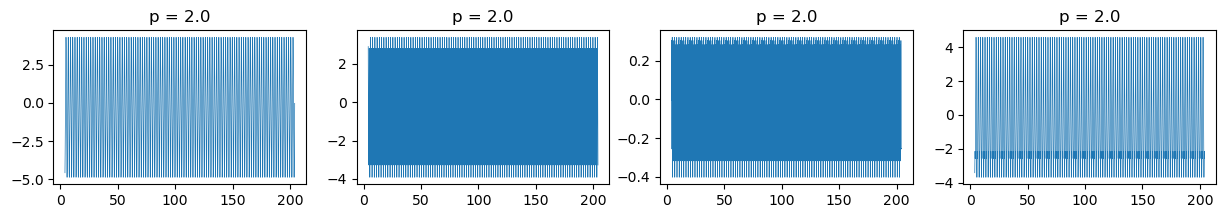

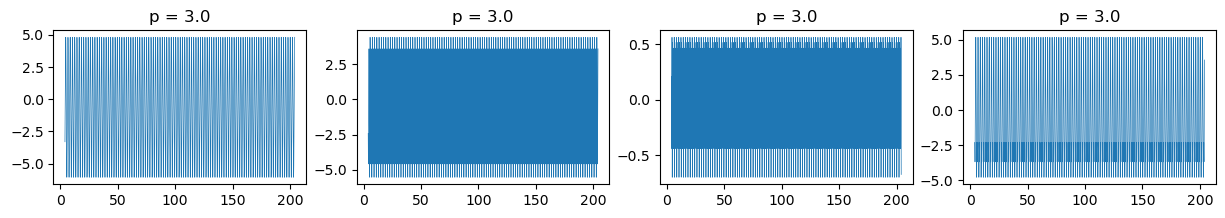

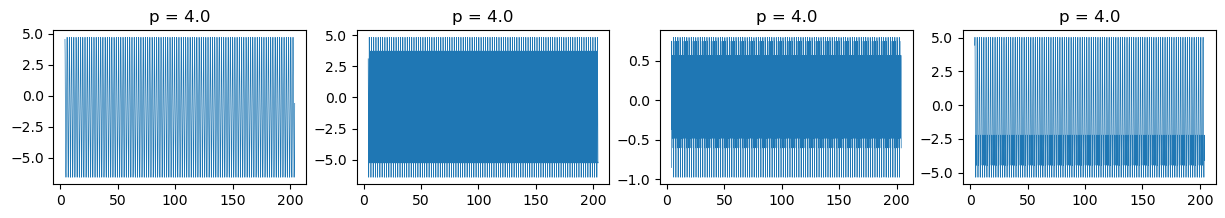

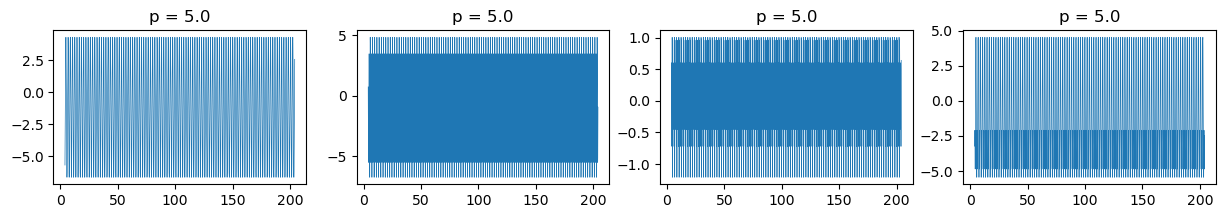

In [14]:
for p_idx in range(len_p_list):
    plt.figure(figsize = (15,2))
    for j, k in enumerate([0,1,-2,-1]):
        plt.subplot(1,4,j+1)
        plt.plot(t_train[p_idx],U_train[p_idx][:,k],linewidth=0.5)
        plt.title(f"p = {p_list[p_idx]}")
        plt.ylabel(f"")
        # plt.xlim([100,200])

In [77]:
U_mean = np.mean(np.vstack(U_train),axis = 0)
#U_mean = np.zeros(len(U_mean))
U_std = np.std(np.vstack(U_train),axis = 0)
m = np.vstack(U_train).min(axis=0)
M = np.vstack(U_train).max(axis=0)
U_norm = M-m 
scale = (U_mean, U_std)

input_bias = np.array([np.mean(np.abs((U_train[0]-scale[0])/scale[1]))])

In [4]:
from adjoint_esn.validation_v2 import validate as validate_v2

#range for hyperparameters (spectral radius and input scaling)
spec_in     = np.log10(0.001) 
spec_end    = np.log10(1.0)
in_scal_in  = 0.01
in_scal_end = 0.1
u_f_scal_in  = 0.1
u_f_scal_end = 2.0
leak_in     = 0.1    
leak_end    = 0.4
param_var_in = 1.0 
param_var_end = 10.0
param_mean_in = -5.0
param_mean_end = 5.0
grid_range = [[in_scal_in, in_scal_end],[u_f_scal_in, u_f_scal_end],[param_mean_in, param_mean_end],[param_var_in, param_var_end]]
# In case we want to start from a grid_search, 
# the first n_grid_x*n_grid_y points are from grid search
param_names = ['input_scaling','u_f_scaling','parameter_normalization_mean','parameter_normalization_var']
param_scales = ['uniform','uniform','uniform','uniform']
N_washout = 100
N_val = 800
N_transient = 0
reservoir_sizes = [1200]
connectivities = [3]
# min_dicts = [[None]*1]*4
for r_idx, reservoir_size in enumerate(reservoir_sizes):
    for c_idx, connectivity in enumerate(connectivities):
        print("Reservoir size", reservoir_size, "Connectivity", connectivity)
        ESN_dict = {'reservoir_size': reservoir_size, 
                    #'dimension' : dim, 
                    'N_g' : N_g,
                    'x_f' : 0.2,
                    'tau' : 0.2,
                    'dt' : 0.01,
                    'u_f_order': u_f_order,
                    'parameter_dimension' : 1,
                    #'reservoir_connectivity' : connectivity,
                    'input_normalization': scale, 
                    'input_bias' : np.array([]),
                    'output_bias' : np.array([]),
                    'parameter_normalization': [np.array([0.0]),np.array([1.0])],
                    'r2_mode': False,
                    'input_weights_mode': "sparse_grouped_rijke_dense",
                    #'input_only_mode': True,
                    'step_mode': 'step2'
                    }
        min_dict = validate_v2(grid_range,param_names,param_scales,
            n_calls = 250, n_initial_points = 200, n_ensemble = 1,
            ESN_dict = ESN_dict, ESN_type = "rijke_input_only", tikh = 1e-3, 
            U_washout_train = U_washout_train,
            U_train = U_train,
            U_val = U_val,
            Y_train = Y_train,
            Y_val = Y_val,
            P_washout_train = P_washout_train,
            P_train = P_train,
            P_val = P_val,
            n_folds = 4,
            n_realisations=1,
            N_washout_steps = N_washout,
            N_val_steps = N_val,
            N_transient_steps = N_transient,
            train_idx_list = [0,1,2,3,4],
            val_idx_list = [0,1,2,3,4])
        # min_dicts[r_idx][c_idx] = min_dict

Reservoir size 1200 Connectivity 3
Running 1/1 of ensemble.
--NEW RUN-- 1
input_scaling 0.06335601564025166
u_f_scaling 1.7041049223039333
parameter_normalization_mean 3.57945617622757
parameter_normalization_var 8.62526564905713


Realisation: 0
Val regime: 0
Val regime error: 5.004339157104971
Val regime: 1
Val regime error: 6.628700339472722
Val regime: 2
Val regime error: 3.9677377740926385
Val regime: 3
Val regime error: 4.781310637511959
Val regime: 4
Val regime error: 4.133486311052617
Realisation error: 24.51557421923491


Run 1 error: 24.51557421923491


--NEW RUN-- 2
input_scaling 0.06612073271073753
u_f_scaling 0.8303252438561298
parameter_normalization_mean -2.0246539345552765
parameter_normalization_var 1.5104167958569887


Realisation: 0
Val regime: 0
Val regime error: 0.06219245831231564
Val regime: 1
Val regime error: 0.03149593478429281
Val regime: 2
Val regime error: 0.06401467720297196
Val regime: 3
Val regime error: 0.07063802817139249
Val regime: 4
Val regime error

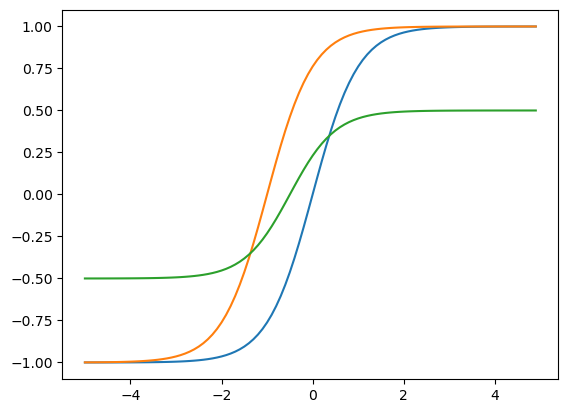

In [200]:
x = np.arange(-5,5,0.1)
plt.plot(x, np.tanh(x))
plt.plot(x, np.tanh(x+1))
plt.plot(x, 0.5*np.tanh(x+0.5))
# plt.plot(x, np.tanh(x**2))
# plt.plot(x, np.tanh(10*x**2+x+1)+np.tanh(x**2+x-2))
# plt.plot(x, np.tanh(x**2+1)+np.tanh(x+1))

In [ ]:
# Notes:
# small input scaling, input can't drive the system anymore we get fixed point
# decrease tikhonov, then the weights are bigger, input can drive the system?

# input states not scaled
reservoir_size = 300, 
reservoir_connectivity = 3, 
spectral_radius = 0.4535063164907469,
input_scaling = 0.06856125576980092,
leak_factor = 0.40365654437554166,
parameter_normalization=[np.array([0.0]),np.array([1.0])],
train_list=[1,2,3,4]
tikh = 1e-1
# parameter_normalization_var = 1.0, limit cycle and fixed point after 4.0
# parameter_normalization_var = 5.0, start seeing quasiperiodic and chaotic after 4.0, but doesn't go to fixed point at 0.5, and doesn't fit 1.0 that well
# probably need to scale each input separately, probably that's the reason why the third mode's amplitude is small
# and at some point the system is dominated by the second mode and not first, but the esn predicts that the first mode is always dominant
# parameter normalization var determines the nonlinear transitions

train_list=[1,2,3,4,5]
tikh = 1
# the amplitude starts going down after the training range, if training until 5 then it starts going down after that, 
# if until 4 then after that and so on

# mapping from reservoir to input is learned by the readout, mapping from input to reservoir is random
# each mode contributes uniformly randomly, the mode coefficient determines which one is dominant 

reservoir_size = 1200, 
reservoir_connectivity = 20, 
spectral_radius = 0.6517571120957193,
input_scaling = 0.6378185800348745,
leak_factor = 0.1893523153230765,
parameter_normalization=[np.array([0.0]),np.array([10])],
train_list=[1,2,3,4,5]
tikh = 1e-1
# increasing input scale, it started capturing the higher modes
tikh = 1
# amplitudes are all wrong but it got chaos at 7, and back to limit cycle at 7.5
# at 0.5 it also predicts chaos instead of fixed point

reservoir_size = 1200, 
reservoir_connectivity = 20, 
spectral_radius = 0.82034062,
input_scaling = 0.56788701,
leak_factor = 0.18411351,
parameter_normalization=[np.array([4.2630588]),np.array([2.97317638])],
train_list=[1,2,3,4,5]
#tikh = 1e-1, limit cycles after 5.0
#tikh = 1e-3, got chaos at 7, wrong amplitude

reservoir_size = 1200, # reservoir sizes 400,800 work as well, seems to change where the bifurcation occurs?
reservoir_connectivity = 20, 
spectral_radius = 0.75460178,    
input_scaling = 0.68803003,
leak_factor = 0.15127487,
parameter_normalization=[np.array([8.88043705]),np.array([5.1122118])],
train_list=[1,2,3,4,5]
tikh = 1e-3

reservoir_size = 1200, 
reservoir_connectivity = 20, 
spectral_radius = 0.91774974, 
input_scaling = 0.85238146, 
leak_factor =  0.34279754, 
parameter_normalization=[np.array([6.93478736,]),np.array([5.54687266])], 
train_list=[1,2,3,4,5]
tikh = 1e-3

reservoir_size = 1200, 
reservoir_connectivity = 20, 
spectral_radius = 0.48622245,  
input_scaling = 0.91058511, 
leak_factor = 0.18513539,
parameter_normalization=[np.array([4.98820854,]),np.array([2.67167293])],
train_list=[1,1.5,2,2.5,3,3.5,4,4.5,5]
tikh = 1e-3


# GOT THIS REALLY RANDOMLY BUT LOOKS GOOD
reservoir_size = 800, 
N_g = N_g,
x_f = 0.2,
tau = 0.2,
dt = 0.01,
parameter_dimension = 1, 
reservoir_connectivity = 3, 
spectral_radius = 0.1,                               
input_scaling = 0.8,
leak_factor = 0.2,
parameter_normalization=[np.array([8]),np.array([5])],

RijkeESN(reservoir_size = 1200, 
            N_g = N_g,
            x_f = 0.2,
            tau = 0.2,
            dt = 0.01,
            parameter_dimension = 1, 
            reservoir_connectivity = 3, 
            spectral_radius = 0.1,                                
            input_scaling = 1.76682512,     
            leak_factor = 0.15830267,
            parameter_normalization=[np.array([15.46652019]),np.array([19.51091461])],
            input_only_mode = True,
            input_weights = "sparse2")

my_ESN = RijkeESN(reservoir_size = 1200, 
            N_g = N_g,
            x_f = 0.2,
            tau = 0.2,
            dt = 0.01,
            parameter_dimension = 1, 
            reservoir_connectivity = 3, 
            spectral_radius = 0.1,    
            input_scaling = 0.07, 
            u_f_scaling= 1.5,
            leak_factor = 1.0,
            parameter_normalization=[np.array([0.0]),np.array([1.5])],
            input_bias = np.array([]),
            output_bias = np.array([]),
            input_normalization = scale, 
            r2_mode=False,
            input_seeds=[1,2,3],
            reservoir_seeds=[4,5],
            input_weights_mode="sparse2_rijke",
            input_only_mode=True,)

### BEST ONE SO FAR: Gets the gradient right, a bit wiggly around 5, gets the bifurcation points right
# gets the quasiperiodic and chaotic, statistics are not %100 but still impressive!
my_ESN = RijkeESN(reservoir_size = 1200, 
            N_g = N_g,
            u_f_order = u_f_order,
            x_f = 0.2,
            tau = 0.2,
            dt = 0.01,
            parameter_dimension = 1, 
            reservoir_connectivity = 3, 
            spectral_radius = 0.1,    
            input_scaling = 0.1130046 ,                             
            u_f_scaling= 1.39332475,
            leak_factor =0.20882743,
            parameter_normalization=[np.array([-2.12880738,]),np.array([1.38678768])],
            input_bias = np.array([]),
            output_bias = np.array([]),
            input_normalization = scale, 
            r2_mode=False,
            input_seeds=[11,22,3],
            reservoir_seeds=[4,5],
            input_weights_mode="sparse_grouped_rijke_dense",
            input_only_mode=True,)
tikhonov = 1e-3,
# also good hyperparameters; [0.13204683,  0.32862271,  1.14705038, -3.6809675 ,  2.80464412]

my_ESN = RijkeESN(reservoir_size = 1800, 
            N_g = N_g,
            u_f_order = u_f_order,
            x_f = 0.2,
            tau = 0.2,
            dt = 0.01,
            parameter_dimension = 1, 
            reservoir_connectivity = 3, 
            spectral_radius = 0.1,    
            input_scaling = 0.08256408,                                       
            u_f_scaling = 1.36869035, 
            leak_factor = 0.20453469,
            parameter_normalization=[np.array([-2.33530715,]),np.array([1.56908385])],
            input_bias = np.array([]),
            output_bias = np.array([]),
            input_normalization = scale, 
            r2_mode=False,
            input_seeds=[1,2,3],
            reservoir_seeds=[4,5],
            input_weights_mode="sparse_grouped_rijke_dense",
            input_only_mode=True,)
# when training with [1,2,3,4,5,6,7,8,9]
# also good: [ 0.05879165,  0.20882743,  1.39332475, -2.12880738,  1.38678768]


# things to look into: dense input weights, solver of the ridge regression, constraining the weights matrices
# what if you pass in the heat release law?
# what if you use pressure and velocity data instead? can we remove the delayed velocity at the flame? Can we add the heat release?
# subcritical bifurcation, hysteresis?
# calculating uf(t-tau) directly and giving it as an input to all inputs
# fixed point, floquet analyses?
# see if it can get the statistics of chaotic with less data
# condition number of the ESN, errors get amplified

reservoir_size = 1200, 
reservoir_connectivity = 20, 
spectral_radius = 0.6221774,
input_scaling = 0.52028844,
leak_factor = 0.12436209,
parameter_normalization=[np.array([7.3139734]),np.array([5.84740945])],
train_list=[1,2,3,4,5,6,8,9]
tikh = 1e-3 # seems to capture the dynamics, but then also converge to other attractors depending on the washout

reservoir_size = 1200,
reservoir_connectivity = 20, 
spectral_radius = 0.18094057, 
input_scaling = 0.92818257,
leak_factor = 0.16492563,
parameter_normalization=[np.array([0.21703727]),np.array([9.44680754])],
train_list=[1,2,3,4,5,6,7,8,9]
tikh = 1e-3, # can now interpolate between quasi, chaotic, except for 7.5 something weird happens, doesn't capture the bifurcation to fixed point either

reservoir_size = 1200, 
reservoir_connectivity = 20, 
spectral_radius = 0.22719225,      
input_scaling = 0.85547937,
leak_factor =  0.16353361, 
parameter_normalization=[np.array([0.08923826]),np.array([10.])]
tikhonov = 1e-3

reservoir_size = 1200, 
reservoir_connectivity = 20, 
spectral_radius = 0.23649333,                     
input_scaling = 0.88227934,
leak_factor = 0.11399726,
parameter_normalization=[np.array([0.33222385,]),np.array([9.84317464])],
tikhonov = 1e-3


reservoir_size = 1200, 
reservoir_connectivity = 20, 
spectral_radius = 0.20160398,                           
input_scaling = 0.84537455,
leak_factor = 0.19066498,
parameter_normalization=[np.array([0.1263459]),np.array([9.80440781])],
input_seeds=[11,12,45]
reservoir_seeds=[41,53]
tikhonov = 1e-3 #bifn to fixed point 0.95
tikhonov = 3e-3 #bifn to fixed point 0.9

reservoir_size = 1800, 
reservoir_connectivity = 30, 
spectral_radius = 0.1043949,                            
input_scaling = 0.41387892,
leak_factor = 0.20478946,
parameter_normalization=[np.array([-3.25588909,]),np.array([18.66057663])],
tikhonov = 1e-3 
# no bifn to fixed point, but the gradient is much better and it doesn't predict 
# the intermittency

reservoir_size = 1800, 
reservoir_connectivity = 30, 
spectral_radius = 0.11785506,                               
input_scaling = 0.4836513,
leak_factor = 0.18897137,
parameter_normalization=[np.array([-1.22030262,]),np.array([13.46840402])],
tikhonov = 1e-3 
# no bifn to fixed point, but the gradient is much better and it doesn't predict 
# the intermittency

In [4]:
print('System dimension: ', dim)
my_ESN = ESN(reservoir_size = 1200, 
            dimension = dim, 
            parameter_dimension = 1, 
            reservoir_connectivity = 20, 
            spectral_radius = 0.91465898,                            
            input_scaling =  0.9496385,
            leak_factor = 0.30048716,
            parameter_normalization=[np.array([7.75984604,]),np.array([3.22040487])],
            output_bias = np.array([]),
            input_normalization = scale, 
            r2_mode=True,
            input_seeds=[11,22,3],
            reservoir_seeds=[4,5])

System dimension:  9
Input normalization is changed, training must be done again.
Parameter normalization is changed, training must be done again.
Input scaling is set to 1, set it separately if necessary.
Input weights are rescaled with the new input scaling.
Spectral radius is set to 1, set it separately if necessary.
Reservoir weights are rescaled with the new spectral radius.


In [ ]:
print('System dimension: ', dim)
my_ESN = ESN(reservoir_size = 800, 
            dimension = dim, 
            parameter_dimension = 0, 
            reservoir_connectivity = 3, 
            spectral_radius = 0.1,                            
            input_scaling = 1.0,
            leak_factor = 1.0,
            parameter_normalization=[np.array([0.0]),np.array([0.5])],
            output_bias = np.array([]),
            input_normalization = scale, 
            r2_mode=False,
            input_weights_mode="sparse2",
            input_only_mode=True,
            input_seeds=[1,2,3],
            reservoir_seeds=[4,5])

In [14]:
print('System dimension: ', dim)
from adjoint_esn.rijke_esn import RijkeESN
my_ESN = RijkeESN(reservoir_size = 1200, 
            N_g = N_g,
            u_f_order = u_f_order,
            x_f = 0.2,
            tau = 0.2,
            dt = 0.01,
            parameter_dimension = 1, 
            reservoir_connectivity = 3, 
            spectral_radius = 0.1,    
            input_scaling = 0.1130046,                             
            u_f_scaling= 1.39332475,
            leak_factor = 0.20882743,
            parameter_normalization=[np.array([-2.12880738,]),np.array([1.38678768])],
            input_bias = np.array([]),
            output_bias = np.array([]),
            input_normalization = scale, 
            r2_mode=False,
            input_seeds=[11,22,3],
            reservoir_seeds=[4,5],
            input_weights_mode="sparse_grouped_rijke_dense",
            input_only_mode=True,)

System dimension:  11
Input normalization is changed, training must be done again.
Parameter normalization is changed, training must be done again.
Input scaling is set to 1, set it separately if necessary.
Input weights are rescaled with the new input scaling.
Input weights of u_f(t-tau) are rescaled with the new input scaling.
Spectral radius is set to 1, set it separately if necessary.
Reservoir weights are rescaled with the new spectral radius.


In [21]:
my_ESN = RijkeESN(reservoir_size = 1800, 
            N_g = N_g,
            u_f_order = u_f_order,
            x_f = 0.2,
            tau = 0.2,
            dt = 0.01,
            parameter_dimension = 1, 
            reservoir_connectivity = 3, 
            spectral_radius = 0.1,    
            input_scaling = 0.08256408,                                       
            u_f_scaling = 1.36869035, 
            leak_factor = 0.20453469,
            parameter_normalization=[np.array([-2.33530715,]),np.array([1.56908385])],
            input_bias = np.array([]),
            output_bias = np.array([]),
            input_normalization = scale, 
            r2_mode=False,
            input_seeds=[11,22,33],
            reservoir_seeds=[4,5],
            input_weights_mode="sparse_grouped_rijke_dense",
            input_only_mode=True,)

Input normalization is changed, training must be done again.
Parameter normalization is changed, training must be done again.
Input scaling is set to 1, set it separately if necessary.
Input weights are rescaled with the new input scaling.
Input weights of u_f(t-tau) are rescaled with the new input scaling.
Spectral radius is set to 1, set it separately if necessary.
Reservoir weights are rescaled with the new spectral radius.


In [37]:
from adjoint_esn.input_only_esn import InputOnlyESN

my_ESN = InputOnlyESN(reservoir_size = 200, 
            dimension=dim,
            parameter_dimension = 1,                               
            input_scaling = 0.06,     
            leak_factor = 0.2,
            input_normalization = scale, 
            parameter_normalization=[np.array([8.0]),np.array([5.0])],
            input_weights_mode = "sparse_grouped",
            input_seeds=[1,2,3],
            step_mode="step2")

Input normalization is changed, training must be done again.
Parameter normalization is changed, training must be done again.
Input scaling is set to 1, set it separately if necessary.
Input weights are rescaled with the new input scaling.


In [54]:
print('System dimension: ', dim)
from adjoint_esn.rijke_input_only_esn import RijkeInputOnlyESN
my_ESN = RijkeInputOnlyESN(reservoir_size = 1800, 
            N_g = N_g,
            u_f_order = u_f_order,
            x_f = 0.2,
            tau = 0.2,
            dt = 0.01,
            parameter_dimension = 1, 
            input_scaling = 0.05936672,                                     
            u_f_scaling =  1.08732138,
            leak_factor =  0.2, 
            parameter_normalization=[np.array([-1.51217336,]),np.array([1.22157961])],
            input_bias = np.array([]),
            output_bias = np.array([]),
            input_normalization = scale, 
            r2_mode=False,
            input_seeds=[11,22,3],
            input_weights_mode="sparse_grouped_rijke_dense",
            step_mode="step2")

System dimension:  9
Input normalization is changed, training must be done again.
Parameter normalization is changed, training must be done again.
Input scaling is set to 1, set it separately if necessary.
Input weights are rescaled with the new input scaling.
Input weights of u_f(t-tau) are rescaled with the new input scaling.


In [15]:
my_ESN.train(U_washout_train, U_train, Y_train, tikhonov = 1e-3, P_washout=P_washout_train, P_train=P_train,
              train_idx_list=np.arange(len(p_list)), sample_weights=None)

(-0.1, 0.1)

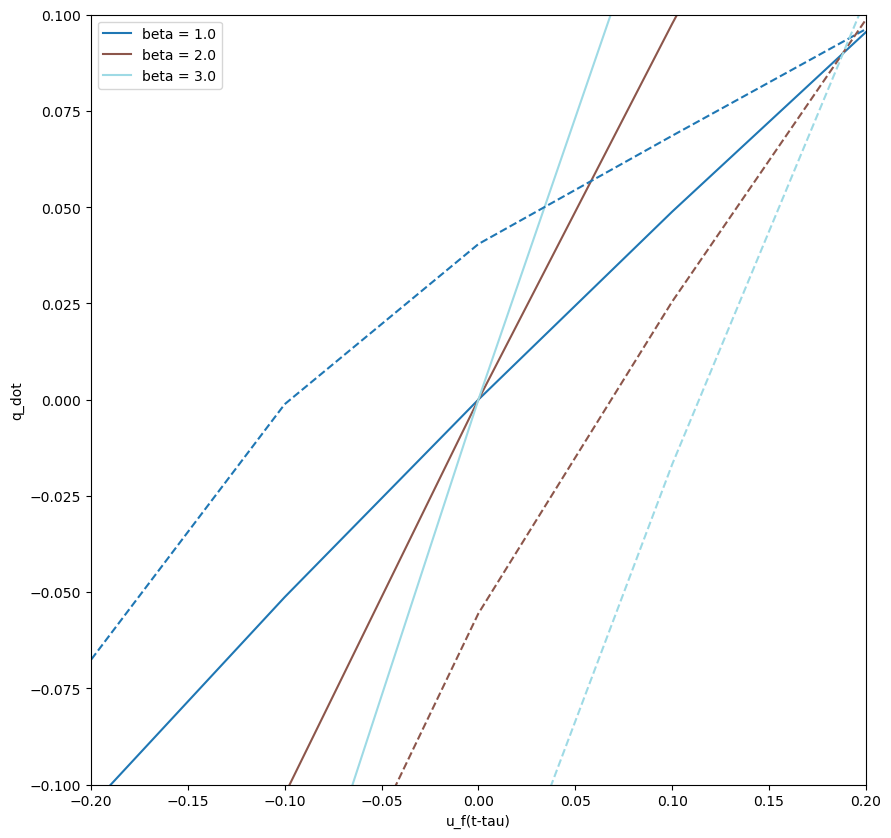

In [10]:
# j = np.arange(1,N_g+1,1)
# plt.figure(figsize = (12,4))
# plt.subplot(1,2,1)
# plt.plot(my_ESN.W_out[u_f_idx,N_g:])
# plt.subplot(1,2,2)
# plt.plot(my_ESN.W_out[u_f_idx,N_g:]/np.sin(j*np.pi*0.2))

# CHECK FOR BUGS IN THIS, the optimal ones seem rotated?
u_f_tau = np.arange(-10,10,0.1)

# beta_list = np.arange(0.3,1.0,0.1)
beta_list = np.arange(1.0,4.0,1.0)
# beta_list = np.arange(5.0,10.0,1.0)

# beta_list = np.arange(0.5,9.5,0.5)

q_dot_true = np.zeros((len(beta_list),len(u_f_tau)))
for beta_idx, beta in enumerate(beta_list):
    my_rijke = Rijke(N_g=N_g,N_c=10,c_1=0.1,c_2=0.06,beta=beta,x_f=0.2,tau=tau,
                    heat_law="kings_poly",damping="modal")
    for u_f_tau_idx, u_f_tau_t in enumerate(u_f_tau):
        q_dot_true[beta_idx,u_f_tau_idx] = my_rijke.kings_poly(u_f_tau_t)

q_dot = np.zeros((len(beta_list),len(u_f_tau)))
for beta_idx, beta in enumerate(beta_list):
    if my_ESN.input_weights_mode == "sparse_grouped_rijke":
        for order in range(u_f_order):
            u_f_idx = np.where(my_ESN.W_in[:,-my_ESN.N_param_dim-(u_f_order-order)].toarray() != 0)[0]
            w_in_u_f = my_ESN.W_in[u_f_idx,-my_ESN.N_param_dim-(u_f_order-order)].toarray()*(u_f_tau**(order+1))
            w_in_beta = my_ESN.W_in[u_f_idx,-1].toarray()*((beta - my_ESN.norm_p[0]) / my_ESN.norm_p[1])
            
            q_dot[beta_idx] = q_dot[beta_idx] + np.dot(my_ESN.W_out[u_f_idx,N_g], np.tanh(w_in_u_f+w_in_beta))

    elif my_ESN.input_weights_mode == "sparse_grouped_rijke_dense":
        u_f_idx = np.where(my_ESN.W_in[:,-my_ESN.N_param_dim].toarray() != 0)[0]
        w_in_beta = my_ESN.W_in[u_f_idx,-1].toarray()*((beta - my_ESN.norm_p[0]) / my_ESN.norm_p[1])

        w_in_u_f = 0
        for order in range(u_f_order):
            w_in_u_f = w_in_u_f + my_ESN.W_in[u_f_idx,-my_ESN.N_param_dim-(u_f_order-order)].toarray()*(u_f_tau**(order+1))

        q_dot[beta_idx] = np.dot(my_ESN.W_out[u_f_idx,N_g], np.tanh(w_in_u_f+w_in_beta))

    q_dot[beta_idx] = -(my_ESN.leak_factor)*q_dot[beta_idx]/(2*0.01*np.sin(np.pi*0.2))

color = plt.cm.tab20(np.linspace(0,1,len(beta_list)))
plt.figure(figsize=(10,10))
for beta_idx in range(len(beta_list)):
    plt.plot(u_f_tau, q_dot_true[beta_idx], color = color[beta_idx])

    plt.xlabel("u_f(t-tau)")
    plt.ylabel("q_dot")
    plt.legend([f"beta = {beta}" for beta in beta_list])

for beta_idx in range(len(beta_list)):
    plt.plot(u_f_tau, q_dot[beta_idx],'--', color = color[beta_idx])
plt.xlim([-0.2,0.2])
plt.ylim([-0.1,0.1])


In [144]:
A1 = np.matmul(my_ESN.W_out.T, my_ESN.W_in.toarray()[:,:2*N_g])

j = np.arange(1, N_g + 1)
modes = np.cos(j * np.pi *0.2)
modes = np.hstack((modes, np.zeros(N_g)))
u_f = np.matmul(my_ESN.W_in.toarray()[:,2*N_g+1][:,None], modes[None,:])

A2 = np.matmul(my_ESN.W_out.T, u_f)

B = np.linalg.inv(np.eye(2*N_g)-(A1+A2))
C = np.matmul(my_ESN.W_out.T, my_ESN.W_in.toarray()[:,-1])
u_star = np.matmul(B,C)

In [10]:
from scipy.optimize import fmin_bfgs
j = np.arange(1, N_g + 1)
modes = np.cos(j * np.pi *0.2)
modes = np.hstack((modes, np.zeros(N_g)))

for p in np.arange(0.3,1.0,0.1):
    def f(u_star): 
        # find u_f(t-tau) = u_f(t)
        u_f = np.dot(modes, u_star)
        u_augmented = np.hstack((u_star, u_f))

        # augment with the parameter
        p_norm = (p - my_ESN.parameter_normalization_mean) / my_ESN.parameter_normalization_var
        u_augmented = np.hstack((u_augmented, p_norm))

        # step
        x_tilde = np.tanh(my_ESN.W_in.dot(u_augmented))

        # output
        next_u_star = np.dot(x_tilde, my_ESN.W_out)

        error = np.linalg.norm(u_star-next_u_star)

        return error

    u0 = 0.3*np.ones(2*N_g)
    opt_u = fmin_bfgs(f, u0)
    print(opt_u)

         Current function value: 0.000000
         Iterations: 64
         Function evaluations: 1073
         Gradient evaluations: 118
[-2.53884985e-01 -2.05222184e-01 -1.35281900e-01 -6.40952336e-02
  2.54213973e-03 -1.19530630e-04 -1.52356178e-03 -3.47569640e-04]
         Current function value: 0.000000
         Iterations: 60
         Function evaluations: 1047
         Gradient evaluations: 115
[-1.65139696e-01 -1.33597762e-01 -8.79186873e-02 -4.18365571e-02
  2.32652757e-03 -1.24817286e-04 -9.95548169e-04 -2.04828225e-04]
         Current function value: 0.000000
         Iterations: 62
         Function evaluations: 1135
         Gradient evaluations: 125
[-0.10759032 -0.0871454  -0.05727762 -0.02733935  0.00201395 -0.00011311
 -0.00060762 -0.00011547]
         Current function value: 0.000000
         Iterations: 60
         Function evaluations: 1399
         Gradient evaluations: 154
[-7.06367986e-02 -5.73395499e-02 -3.76563898e-02 -1.79877041e-02
  1.68656646e-03 -1.024756

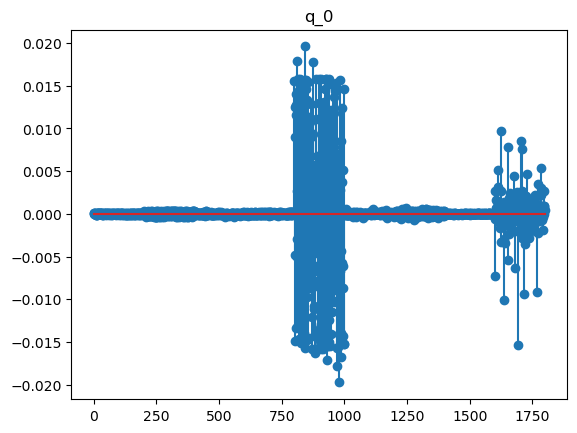

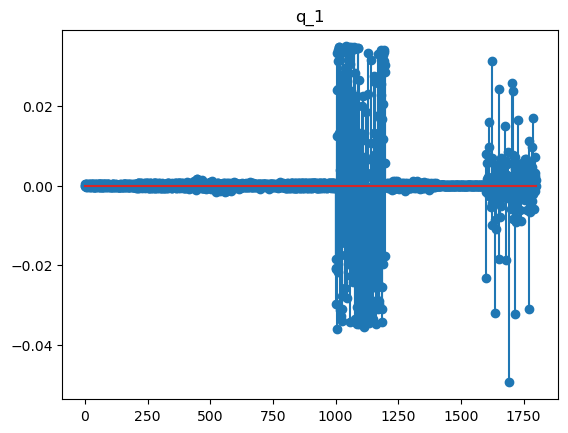

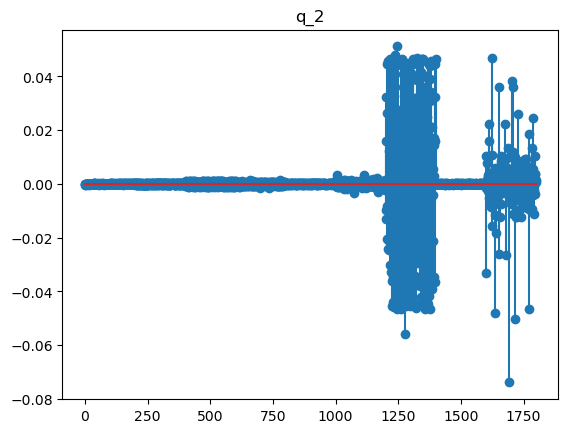

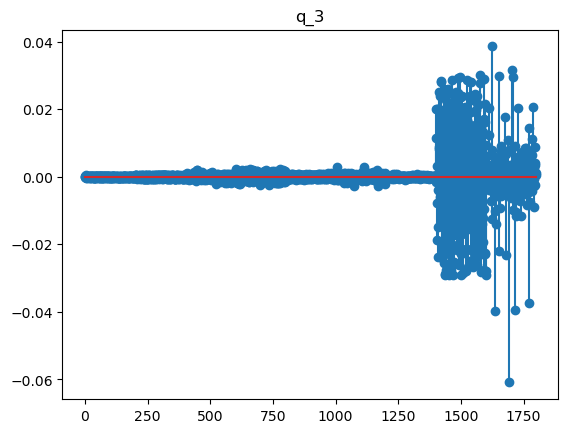

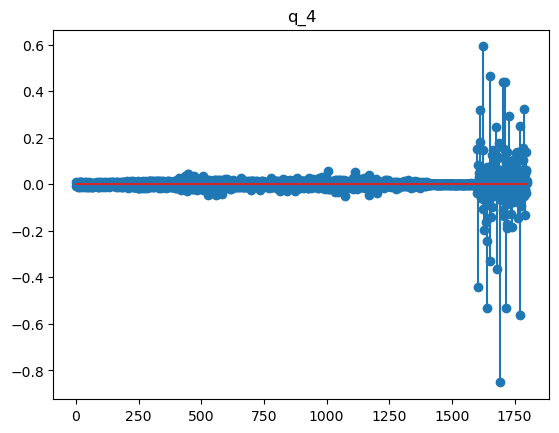

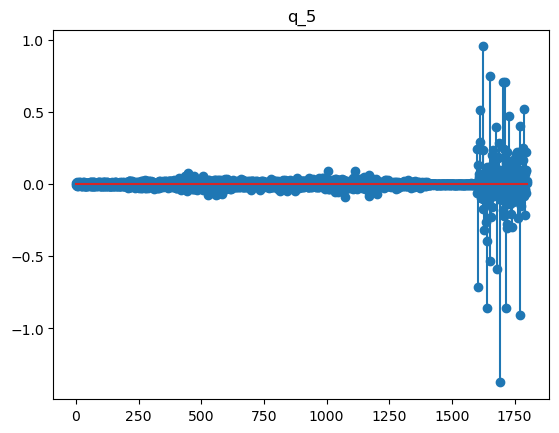

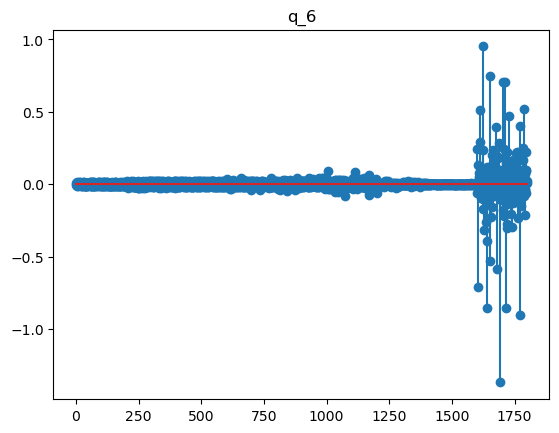

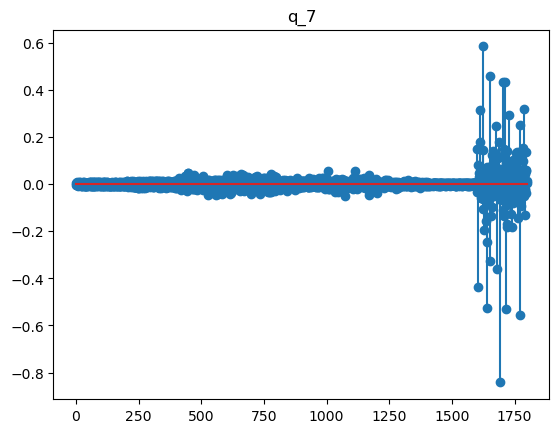

In [45]:
# my_ESN.train(U_washout_train, U_train, Y_train, tikhonov = 1e-3, P_washout=P_washout_train, P_train=P_train,
#               train_idx_list=[0,1,2,3,4], sample_weights=None)

WW1 = my_ESN.output_weights.copy()
# my_ESN.train(U_washout_train, U_train, Y_train, tikhonov = 1e-3, P_washout=P_washout_train, P_train=P_train,
#               train_idx_list=[0,1,2,3,4,5,6,7,8], sample_weights=None)
WW2 = my_ESN.output_weights.copy()
for i in range(8):
    plt.figure()
    plt.stem(WW1[:,i])
    # plt.plot(WW2[:,i])
    # plt.vlines(np.arange(1,10,1)*133, -1, 1, color = "black")
    plt.title(f"q_{i}")

In [23]:
for i in range(9):
    print(f"q_{i}",np.dot(my_ESN.output_weights[i*134:(i+1)*134,7],my_ESN.input_weights.toarray()[i*134:(i+1)*134,i]))

q_0 0.0007131264336963416
q_1 0.00011222108664506636
q_2 -8.481289808846913e-05
q_3 -0.12101947215777359
q_4 -0.00021849681650260716
q_5 -0.0019300112858795793
q_6 -0.0015111391052109692
q_7 -0.027743507057141244
q_8 0.8005050271241614


In [64]:
for i in range(9):
    print(f"q_{i}",np.dot(my_ESN.output_weights[i*1:(i+1)*1,7],my_ESN.input_weights.toarray()[i*1:(i+1)*1,i]))

q_0 -0.0
q_1 -0.0
q_2 -0.0
q_3 -0.09310368821352982
q_4 -0.0
q_5 -0.0
q_6 -0.0
q_7 0.9477916810639275
q_8 0.002259251874066727


In [20]:
0.01*my_rijke.zeta

array([0.0016    , 0.00484853, 0.01003923, 0.0172    ])

In [41]:
j = np.arange(1,N_g+1,1)
j*np.pi

array([ 3.14159265,  6.28318531,  9.42477796, 12.56637061])

In [41]:
sample_weights = []
J_train_tot = np.zeros(len(p_list))
ww1 = np.zeros(len(p_list))
for p_idx in range(len_p_list):
    J_train_tot[p_idx] = np.mean(np.sum(Y_train[p_idx][:,0:2*N_g]**2, axis = 1))
    ww1[p_idx] = (1/J_train_tot[p_idx])/(1/J_train_tot[0])
    sample_weights.extend([ww1[p_idx]]*len(U_train[p_idx]))

my_ESN.train(U_washout_train, U_train, Y_train, tikhonov = 1e-3, P_washout=P_washout_train, P_train=P_train,
              train_idx_list=[0,1,2,3,4,5,6,7,8], sample_weights=sample_weights)

In [15]:
col_maxmin = np.zeros((len_p_list,dim))
for p_idx in range(len_p_list):
    col_maxmin[p_idx,:] = np.max(Y_train[p_idx], axis=0)-np.min(Y_train[p_idx], axis=0)

J_train = np.zeros((len_p_list,dim))
for p_idx in range(len_p_list):
    J_train[p_idx,:] = np.mean(Y_train[p_idx]**2, axis=0)

sample_weights = [[] for j in range(dim)]
ww = np.zeros((len_p_list,dim))
for y_idx in range(dim):
    for p_idx in range(len_p_list):
        # ww[p_idx,y_idx] = (1/col_maxmin[p_idx,y_idx])/(1/col_maxmin[0,y_idx])
        ww[p_idx,y_idx] = (1/J_train[p_idx,y_idx])/(1/J_train[0,y_idx])
        sample_weights[y_idx].extend([ww[p_idx,y_idx]]*len(U_train[p_idx]))

my_ESN.train(U_washout_train, U_train, Y_train, tikhonov = 1e-3, P_washout=P_washout_train, P_train=P_train,
              train_idx_list=[0,1,2,3,4,5,6,7,8], sample_weights=sample_weights)

In [69]:
def L2_error(y, y_pred):
    return np.linalg.norm(y-y_pred, 'fro')

def log10_error(y, y_pred):
    return np.log10(np.mean((y-y_pred)**2))

def col_mse(y_true, y_pred):
    return np.mean((y_true-y_pred)**2, axis = 0)

def mse(y_true, y_pred):
    return np.sum(col_mse(y_true, y_pred))

def rmse(y_true, y_pred):
    return np.sum(np.sqrt(col_mse(y_true, y_pred)))

def nrmse(y_true, y_pred):
    col_maxmin = np.max(y_true, axis=0)-np.min(y_true, axis=0)
    col_rmse = np.sqrt(col_mse(y_true, y_pred))
    return np.sum(col_rmse/col_maxmin)

In [ ]:
for p_idx in range(len_p_list):
    _, Y_pred_train_ = my_ESN.closed_loop_with_washout(U_washout = U_washout_train[p_idx], N_t = len(U_train[p_idx]), P_washout=P_washout_train[p_idx], P = P_train[p_idx])
    Y_pred_train = Y_pred_train_[1:,:]
    est_velocity = Rijke.toVelocity(N_g, eta=Y_pred_train[:,0:N_g], x=np.array([0.2])) 

    plt.figure(figsize=(15,4))
    plt.plot(t_train[p_idx], Y_train[p_idx][:,-1], color ='silver',linewidth = 4)
    plt.plot(t_train[p_idx], Y_pred_train[:,-1],color ='black',linewidth = 1)
    plt.plot(t_train[p_idx][20:], est_velocity[:-20,0],color ='tab:orange',linestyle ='--')
    plt.xlim([175,200])
    plt.title(f"p = {p_list[p_idx]}")
    plt.xlabel("t")
    plt.ylabel("u_f(t-tau)")
    plt.legend(["True","Pred","Est"])

    plt.figure(figsize=(15,4))
    plt.plot(t_train[p_idx], Y_train[p_idx][:,-1]-Y_pred_train[:,-1],color ='black',linewidth = 1)
    plt.plot(t_train[p_idx][20:],Y_train[p_idx][20:,-1]-est_velocity[:-20,0] ,color ='tab:orange',linestyle ='--')
    plt.title(f"p = {p_list[p_idx]}")
    plt.xlim([175,200])
    plt.ylabel("u_f(t-tau) error")
    plt.legend(["Pred","Est"])

    plt.figure(figsize=(15,4))
    plt.plot(t_train[p_idx][20:],Y_pred_train[20:,-1]-est_velocity[:-20,0] ,color ='tab:blue')
    plt.title(f"p = {p_list[p_idx]}")
    plt.xlim([175,200])
    plt.ylabel(["u_f(t-tau) pred-est"])

Train nrms error:  4.570754927072388
Train rms error:  18.22971678455748
Validation nrms error:  4.57130546043509
Validation rms error:  18.236860756662256
Train nrms error:  3.7818668242228384
Train rms error:  19.618017243177817
Validation nrms error:  3.7804637854175485
Validation rms error:  19.609430980494558
Train nrms error:  0.15913873467333353
Train rms error:  0.7351231215887444
Validation nrms error:  0.15747323555987996
Validation rms error:  0.7270231729387525
Train nrms error:  3.348006920516575
Train rms error:  23.175846074292767
Validation nrms error:  3.349151101706353
Validation rms error:  23.179656690752005
Train nrms error:  3.4403995656964916
Train rms error:  25.49056112336656
Validation nrms error:  3.4417412546305064
Validation rms error:  25.494776939530148
Total train nrmse: 15.300166972181627
Total train rmse: 87.24926434698337
Total val nrmse: 15.300134837749379
Total val rmse: 87.24774854037773


Text(0.5, 1.0, 'Energy')

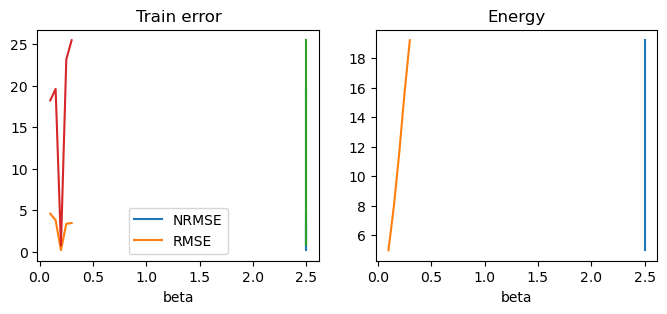

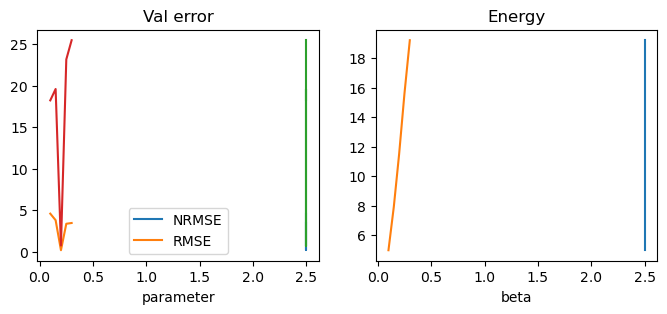

In [7]:
plt_idx = [0,1,2]
plot = False
Y_pred_train = [None]*len_p_list
for p_idx in range(len_p_list):
    _, Y_pred_train_ = my_ESN.closed_loop_with_washout(U_washout = U_washout_train[p_idx], N_t = len(U_train[p_idx]), P_washout=P_washout_train[p_idx], P = P_train[p_idx])
    Y_pred_train[p_idx] = Y_pred_train_[1:,:]
    if plot:
        plt.figure(figsize=(20,4), constrained_layout = True)
        for j, k in enumerate(plt_idx):
            plt.subplot(1,len(plt_idx),j+1)
            plt.plot(t_train[p_idx], Y_train[p_idx][:,k],color="silver",linewidth=2)
            plt.plot(t_train[p_idx], Y_pred_train[p_idx][:,k],color="black",linewidth=0.5)
            plt.title(f"Training time series, p = {p_list[p_idx]}")
            plt.xlabel("t")
            plt.ylabel(f"q_{j}")
            plt.legend(["True", "ESN"])
        
        plt.figure(figsize=(20,4), constrained_layout = True)
        for j, k in enumerate(plt_idx):
            plt.subplot(1,len(plt_idx),j+1)
            plt.plot(t_train[p_idx], Y_train[p_idx][:,k]-Y_pred_train[p_idx][:,k],color="black",linewidth=0.5)
            plt.title(f"Training error, p = {p_list[p_idx]}")
            plt.xlabel("t")
            plt.ylabel(f"q_{j} Error")

Y_pred_val = [None]*len_p_list
for p_idx in range(len_p_list):
    _, Y_pred_val_ = my_ESN.closed_loop_with_washout(U_washout = U_washout_val[p_idx], N_t = len(U_val[p_idx]), P_washout=P_washout_val[p_idx], P = P_val[p_idx])
    Y_pred_val[p_idx] = Y_pred_val_[1:,:]
    if plot:
        plt.figure(figsize=(20,4), constrained_layout = True)
        for j, k in enumerate(plt_idx):
            plt.subplot(1,len(plt_idx),j+1)
            plt.plot(t_val[p_idx][:], Y_val[p_idx][:,k],color="silver",linewidth=4)
            plt.plot(t_val[p_idx][:], Y_pred_val[p_idx][:,k],color="black",linewidth=1)
            plt.title(f"Test time series, p = {p_list[p_idx]}")
            plt.xlabel("t")
            plt.ylabel(f"q_{j}")
            plt.legend(["True", "ESN"])

        plt.figure(figsize=(20,4), constrained_layout = True)
        for j, k in enumerate(plt_idx):
            plt.subplot(1,len(plt_idx),j+1)
            plt.plot(t_val[p_idx][:], Y_val[p_idx][:,k]-Y_pred_val[p_idx][:,k],color="black",linewidth=1)
            plt.title(f"Test error, p = {p_list[p_idx]}")
            plt.xlabel("t")
            plt.ylabel(f"q_{j} Error")

# calculate error
train_error = np.zeros(len(p_list))
train_error2 = np.zeros(len(p_list))
val_error = np.zeros(len(p_list))
val_error2 = np.zeros(len(p_list))
J_train = np.zeros(len(p_list))
J_val = np.zeros(len(p_list))
for p_idx in range(len_p_list):
    J_train[p_idx] = 1/4*np.mean(np.sum(Y_train[p_idx][:,0:2*N_g]**2, axis = 1))
    J_val[p_idx] = 1/4*np.mean(np.sum(Y_val[p_idx][:,0:2*N_g]**2, axis = 1))

    train_error[p_idx] = nrmse(Y_train[p_idx], Y_pred_train[p_idx])
    val_error[p_idx] = nrmse(Y_val[p_idx], Y_pred_val[p_idx])
    train_error2[p_idx] = rmse(Y_train[p_idx], Y_pred_train[p_idx])
    val_error2[p_idx] = rmse(Y_val[p_idx], Y_pred_val[p_idx])
    print("Train nrms error: ", train_error[p_idx])
    print("Train rms error: ", train_error2[p_idx])
    print("Validation nrms error: ", val_error[p_idx])
    print("Validation rms error: ", val_error2[p_idx])
    
print("Total train nrmse:", np.sum(train_error))
print("Total train rmse:", np.sum(train_error2))
print("Total val nrmse:", np.sum(val_error))
print("Total val rmse:", np.sum(val_error2))

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(p_list,train_error)
plt.plot(p_list,train_error2)
plt.plot()
plt.xlabel("beta")
plt.legend(["NRMSE","RMSE"])
plt.title("Train error")
plt.subplot(1,2,2)
plt.plot(p_list,J_train)
plt.plot()
plt.xlabel("beta")
plt.title("Energy")

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(p_list,val_error)
plt.plot(p_list,val_error2)
plt.xlabel("parameter")
plt.legend(["NRMSE","RMSE"])
plt.title("Val error")
plt.subplot(1,2,2)
plt.plot(p_list,J_val)
plt.plot()
plt.xlabel("beta")
plt.title("Energy")

In [93]:
bifn_point = np.zeros(len(tau_test_list))
bifn_point_true = np.zeros(len(tau_test_list))

Tau: 0.05
Train error:  1.3301708012655276
Tau: 0.060000000000000005
Train error:  1.146481703709499
Tau: 0.07
Train error:  0.962324616173819


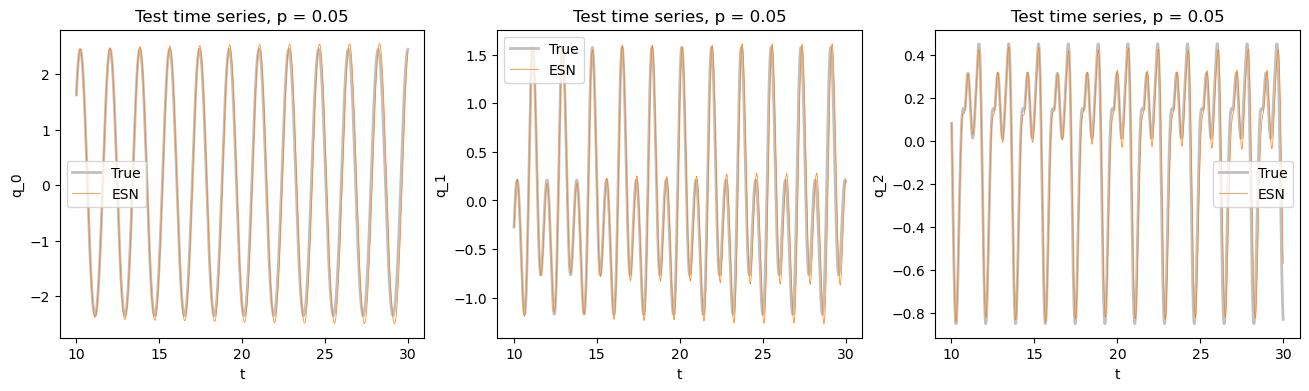

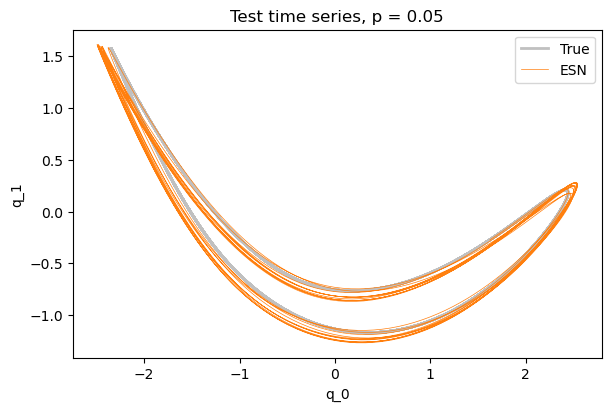

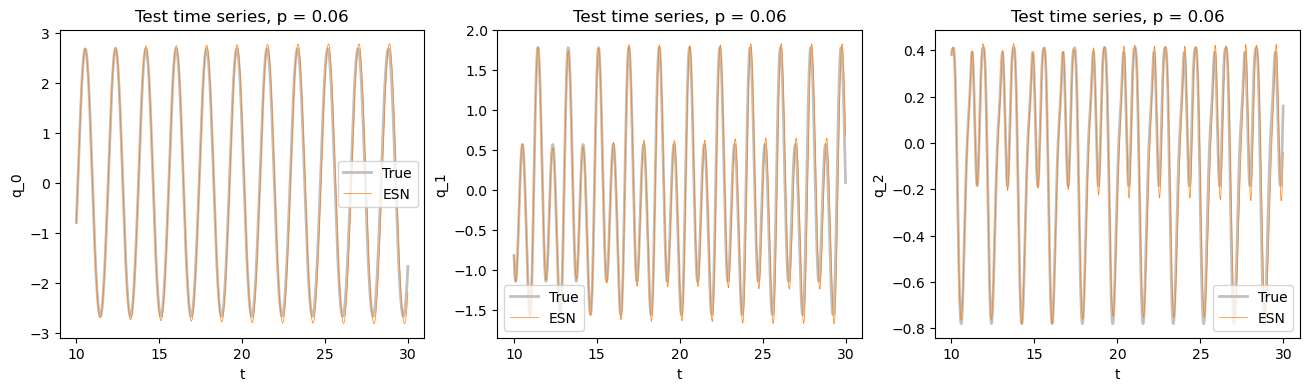

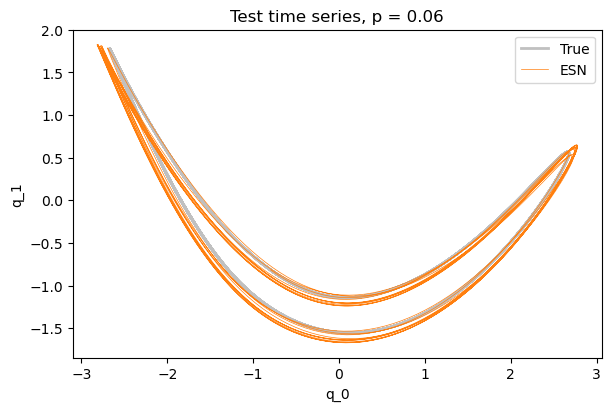

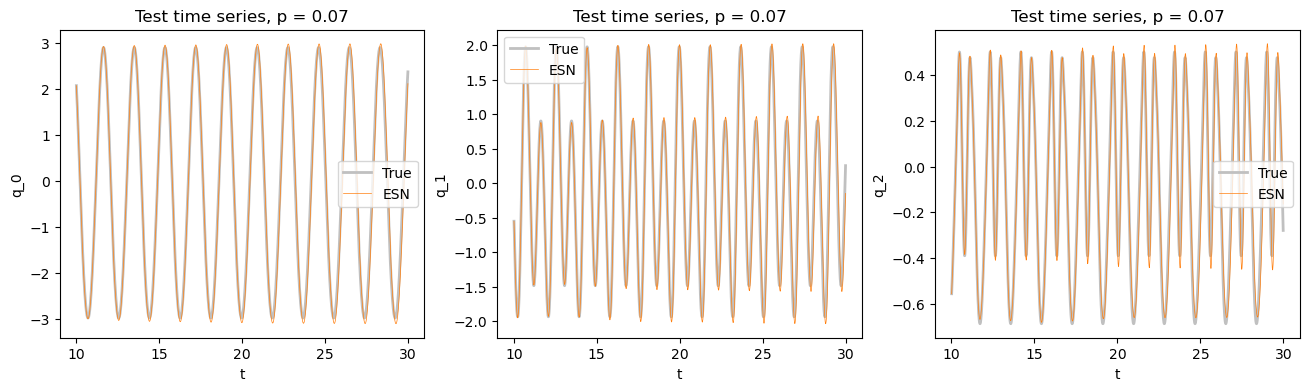

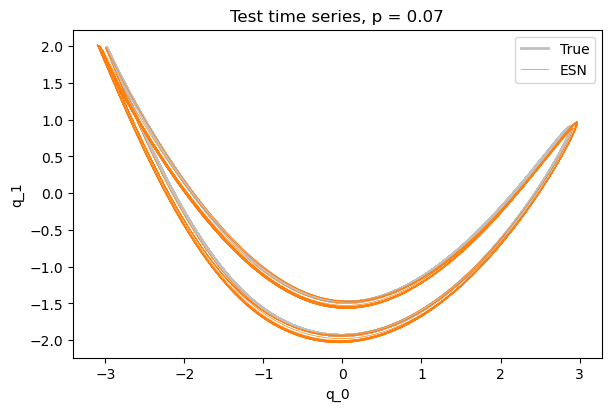

In [71]:
plt_idx = [0,1,2]
sim_dict2 = {"t_sim_len": 230,
            "data_dt": 1e-3,
            "dt": 1e-2,
            "t_transient_len": 200,
            "t_washout_len": 10,
            "t_train_len": 20,
            "t_val_len": 0,
            }
# pp_test_list = np.arange(5.5,9.0,0.5)
pp_test_list = np.arange(0.05,0.07,0.01)
# pp_test_list = np.arange(1.0,5.0,0.5)
# pp_test_list = np.arange(5.0,9.0,1.0)
plt_t_idx = 0
my_ESN.x_f = 0.2
x_f_test = my_ESN.x_f
param = "tau"
#plt.figure(figsize=(12,14), constrained_layout = True)
for test_idx, pp_test in enumerate(pp_test_list): 
    if param == "beta":
        beta_test = pp_test
        print("Beta:", beta_test)
        tau_test = my_ESN.tau
       
    elif param == "tau":
        tau_test = pp_test
        my_ESN.tau = tau_test
        print("Tau:", tau_test)
        beta_test = 2.5
    
    beta_name = f'{beta_test:.2f}'
    beta_name = beta_name.replace(".","_")
    tau_name = f'{tau_test:.2f}'
    tau_name = tau_name.replace(".","_")
    data_path = f"data_new/rijke_kings_poly_N_g_4_beta_{beta_name}_tau_{tau_name}.h5"
    data_path = None
    U_washout_test, U_test, Y_test, t_test, U_washout_testval, U_testval, Y_testval, t_testval = load_data_sys(beta=beta_test,tau=tau_test,x_f=x_f_test,
                                                                                                               N_g=N_g,**sim_dict2,data_path=data_path,u_f_order=u_f_order)
    P_test = beta_test*np.ones((len(U_test),1))
    P_washout_test = beta_test*np.ones((len(U_washout_test),1))
    X_pred_test, Y_pred_test = my_ESN.closed_loop_with_washout(U_washout = U_washout_test, N_t = len(U_test), P_washout=P_washout_test, P = P_test)
    Y_pred_test = Y_pred_test[1:,:]

    # P_testval = beta_test*np.ones((len(U_testval),1))
    # P_washout_testval = beta_test*np.ones((len(U_washout_testval),1))
    # X_pred_testval, Y_pred_testval = my_ESN.closed_loop_with_washout(U_washout = U_washout_testval, N_t = len(U_testval), P_washout=P_washout_testval, P = P_testval)
    # Y_pred_testval = Y_pred_testval[1:,:]
    plt.figure(figsize=(16,4))
    for j, k in enumerate(plt_idx):
        plt.subplot(1,len(plt_idx),j+1)
        plt.plot(t_test[plt_t_idx:], Y_test[plt_t_idx:,k],color="silver",linewidth=2)
        plt.plot(t_test[plt_t_idx:], Y_pred_test[plt_t_idx:,k],color="tab:orange",linewidth=0.5)
        plt.title(f"Test time series, p = {pp_test:4.2f}")
        plt.xlabel("t")
        plt.ylabel(f"q_{j}")
        plt.legend(["True", "ESN"])

    plt.figure(figsize=(6,4), constrained_layout = True)
    plt.plot(Y_test[plt_t_idx:,0], Y_test[plt_t_idx:,1],color="silver",linewidth=2)
    plt.plot(Y_pred_test[plt_t_idx:,0], Y_pred_test[plt_t_idx:,1],color="tab:orange",linewidth=0.5)
    plt.title(f"Test time series, p = {pp_test:4.2f}")
    plt.xlabel("q_0")
    plt.ylabel(f"q_1")
    plt.legend(["True", "ESN"])

    test_error = rmse(Y_test, Y_pred_test)
    # testval_error = rmse(Y_testval, Y_pred_testval)
    print("Train error: ", test_error)
    # print("Validation error: ", testval_error)
    # print("Predicted fixed point", Y_pred_test[-1,:])
    
    # u_star_p = u_star*(pp_test-my_ESN.parameter_normalization_mean)/my_ESN.parameter_normalization_var
    # print(u_star_p)

In [42]:
# Hopf bifurcation curve
sim_dict2 = {"t_sim_len": 400,
            "data_dt": 1e-2,
            "dt": 1e-2,
            "t_transient_len": 200,
            "t_washout_len": 10,
            "t_train_len": 100,
            "t_val_len": 0,
            }
pp_test_list = np.arange(0.2,1.8,0.02)
tau_test_list = np.arange(0.02,0.4,0.02)
plt_t_idx = 0


# data_path = f"data_new/rijke_kings_poly_N_g_4_beta_0_60_tau_0_20.h5"
bifn_point = np.zeros(len(tau_test_list))
bifn_point_true = np.zeros(len(tau_test_list))
# @todo: change to while loop while Y_1_energy - Y_2_energy
# take transient out of test 
for tau_idx, tau_test in enumerate(tau_test_list):
    for test_idx, pp_test in enumerate(pp_test_list): 
        data_path = None
        U_washout_test, U_test, Y_test, t_test, _, _, _, _ = load_data_sys(beta=pp_test,tau=tau_test,N_g=N_g,**sim_dict2,data_path=data_path)
        P_washout_test = pp_test*np.ones((len(U_washout_test),1))

        Y_1_true = Y_test[0:5000,:]
        Y_2_true = Y_test[5000:10000,:]
        Y_1_energy_true = 1/4*np.mean(np.sum(Y_1_true**2, axis = 1))
        Y_2_energy_true = 1/4*np.mean(np.sum(Y_2_true**2, axis = 1))
        print(Y_1_energy_true)
        print(Y_2_energy_true)
        if Y_1_energy_true-Y_2_energy_true > 0.05*Y_2_energy_true:
        # if Y_2_energy_true < 0.1:
            bifn_point_true[tau_idx] = pp_test
            print("tau =",tau_test, "bifn point true =",bifn_point_true[tau_idx])

        my_ESN.tau = tau_test
        N_t = len(U_test)
        P_test = pp_test*np.ones((N_t,1))
        X_pred_test, Y_pred_test = my_ESN.closed_loop_with_washout(U_washout = U_washout_test, N_t = N_t, P_washout=P_washout_test, P = P_test)
        Y_pred_test = Y_pred_test[1:,:]
        Y_1 = Y_pred_test[0:5000,:]
        Y_2 = Y_pred_test[5000:10000,:]
        Y_1_energy = 1/4*np.mean(np.sum(Y_1**2, axis = 1))
        Y_2_energy = 1/4*np.mean(np.sum(Y_2**2, axis = 1))
        print(Y_1_energy)
        print(Y_2_energy)
        if Y_1_energy-Y_2_energy > 0.05*Y_2_energy:
        # if Y_2_energy < 0.1:
            bifn_point[tau_idx] = pp_test
            print("tau =",tau_test, "bifn point =",bifn_point[tau_idx])

        if Y_1_energy_true-Y_2_energy_true <= 0.1*Y_1_energy_true and Y_1_energy-Y_2_energy <= 0.1*Y_1_energy:
            break

plt.plot(bifn_point_true,tau_test_list)
plt.plot(bifn_point,tau_test_list,'--')
plt.xlabel("beta")
plt.ylabel("tau")
plt.legend(["True","ESN"])

1.5211494329725008e-15
1.61795399692199e-23
tau = 0.02 bifn point true = 0.2
0.0013778834166810153
0.0012884651357974702
tau = 0.02 bifn point = 0.2
6.334362022511226e-15
6.411404333555934e-15
0.0012082426344175196
0.0011291810460967865
tau = 0.02 bifn point = 0.22
9.314461119931032e-15
7.282623457647678e-15
tau = 0.04 bifn point true = 0.2
0.0013734768389323988
0.0012884395782182042
tau = 0.04 bifn point = 0.2
5.183086482489011e-15
2.3967459191340673e-23
tau = 0.04 bifn point true = 0.22
0.0012045162551887977
0.0011291594078163345
tau = 0.04 bifn point = 0.22
1.0305253577082638e-14
1.2535821396062545e-14
0.0010511730688158379
0.0009847120984617591
tau = 0.04 bifn point = 0.24
8.723156657670514e-15
9.869874558722052e-15
0.001369594478347793
0.0012884210646011294
tau = 0.06 bifn point = 0.2
2.4435385818039872e-14
4.52495695157861e-15
tau = 0.08 bifn point true = 0.2
0.0013661664892301527
0.0012884074934580304
tau = 0.08 bifn point = 0.2
2.924569238870417e-14
7.718365278198466e-15
tau = 

KeyboardInterrupt: 

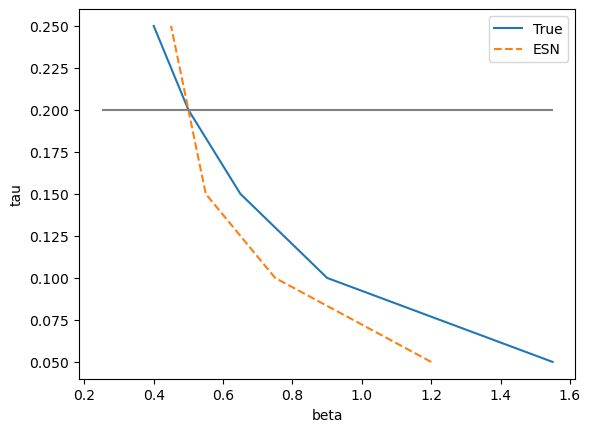

In [151]:
plt.plot(bifn_point_true,tau_test_list)
plt.plot(bifn_point,tau_test_list,'--')
plt.hlines(y = 0.2, xmin = 0.25, xmax = 1.55, color = "grey")
plt.hlines(y = 0.3, xmin = 0.25, xmax = 1.55, color = "grey")
plt.xlabel("beta")
plt.ylabel("tau")
plt.legend(["True","ESN"])

prediction started
Beta: 1.0
1.0
Beta: 1.5
1.5
Beta: 2.0
2.0
Beta: 2.5
2.5
Beta: 3.0
3.0
Beta: 3.5
3.5
Beta: 4.0
4.0
Beta: 4.5
4.5


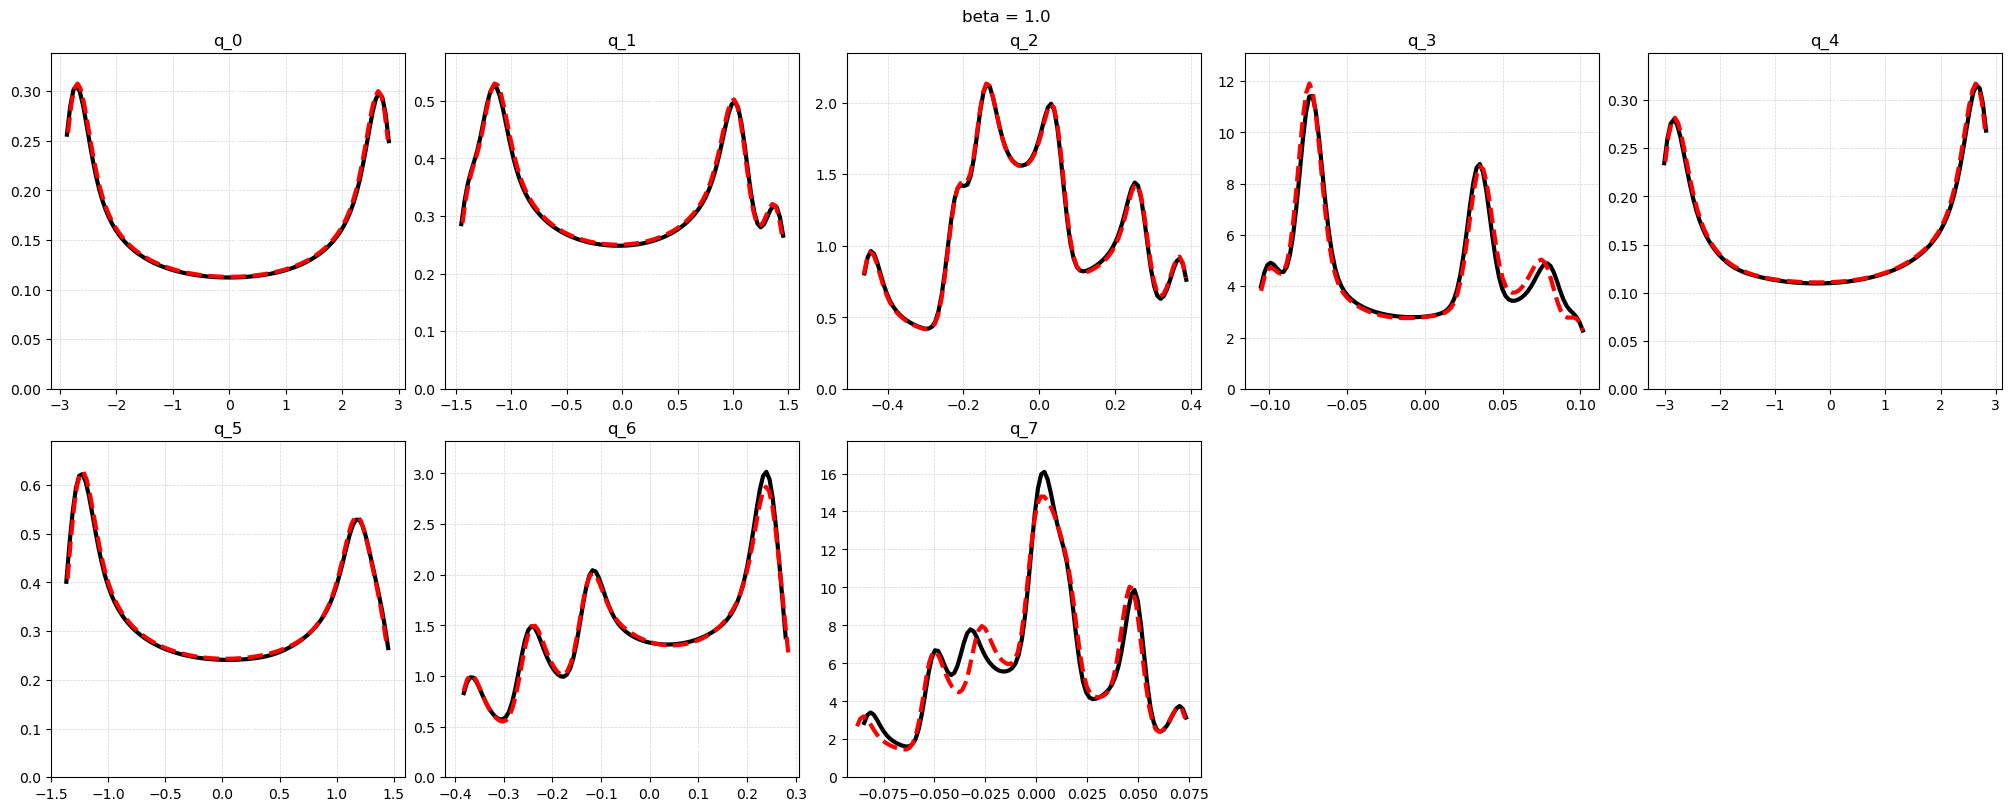

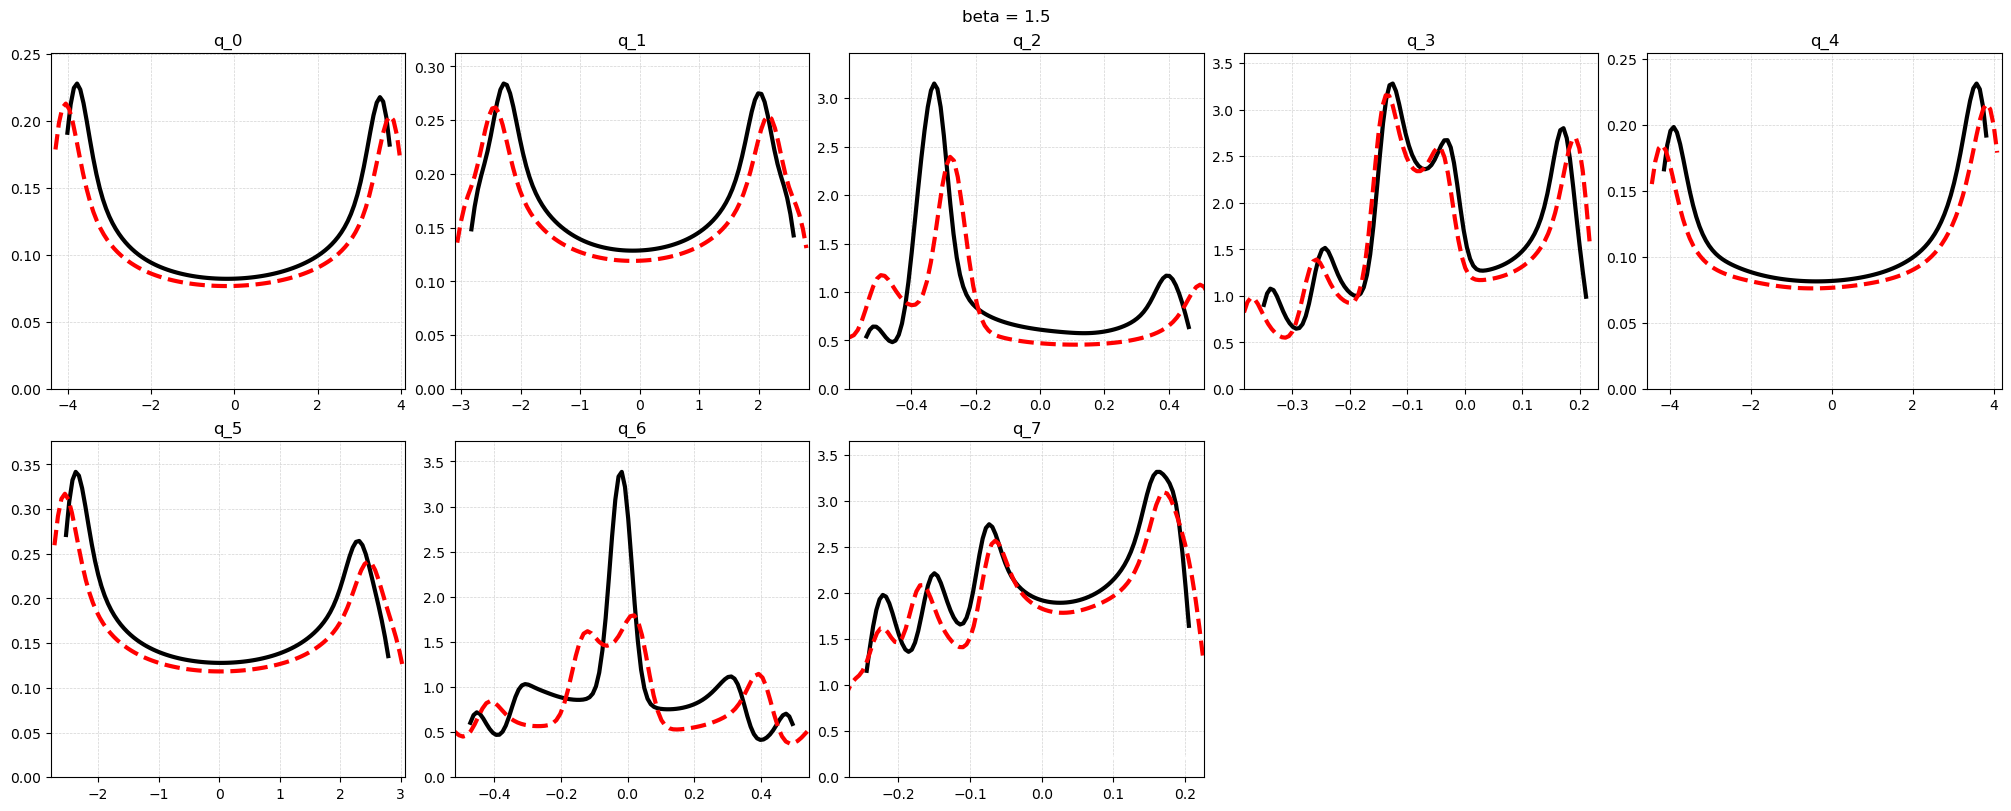

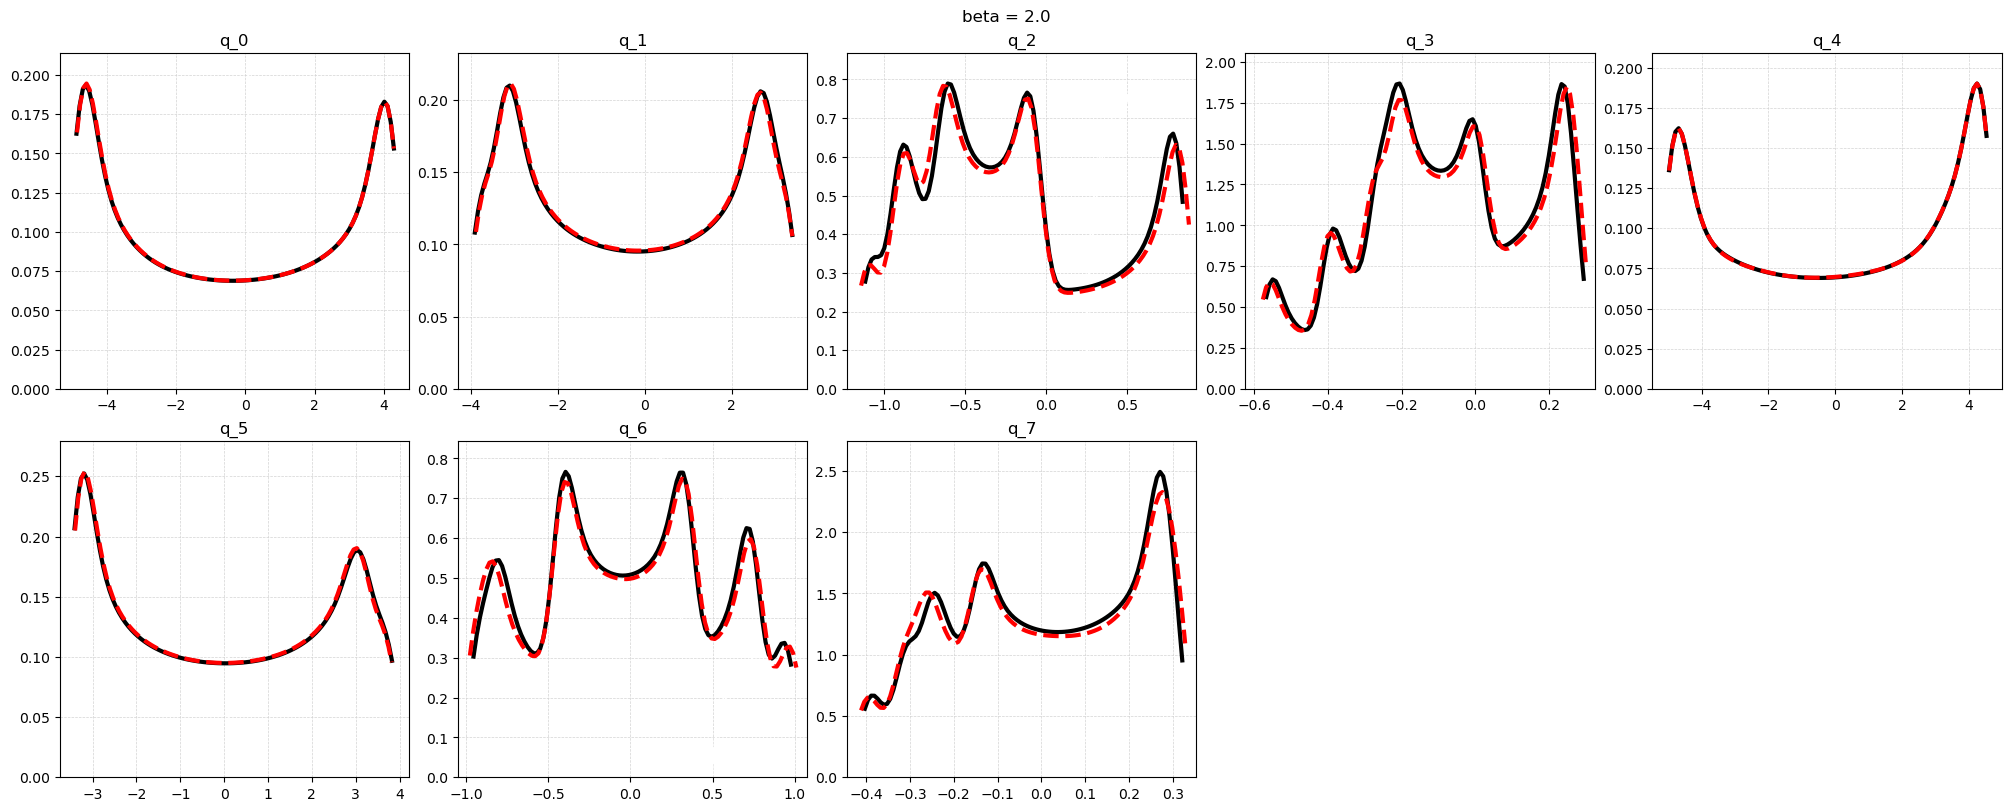

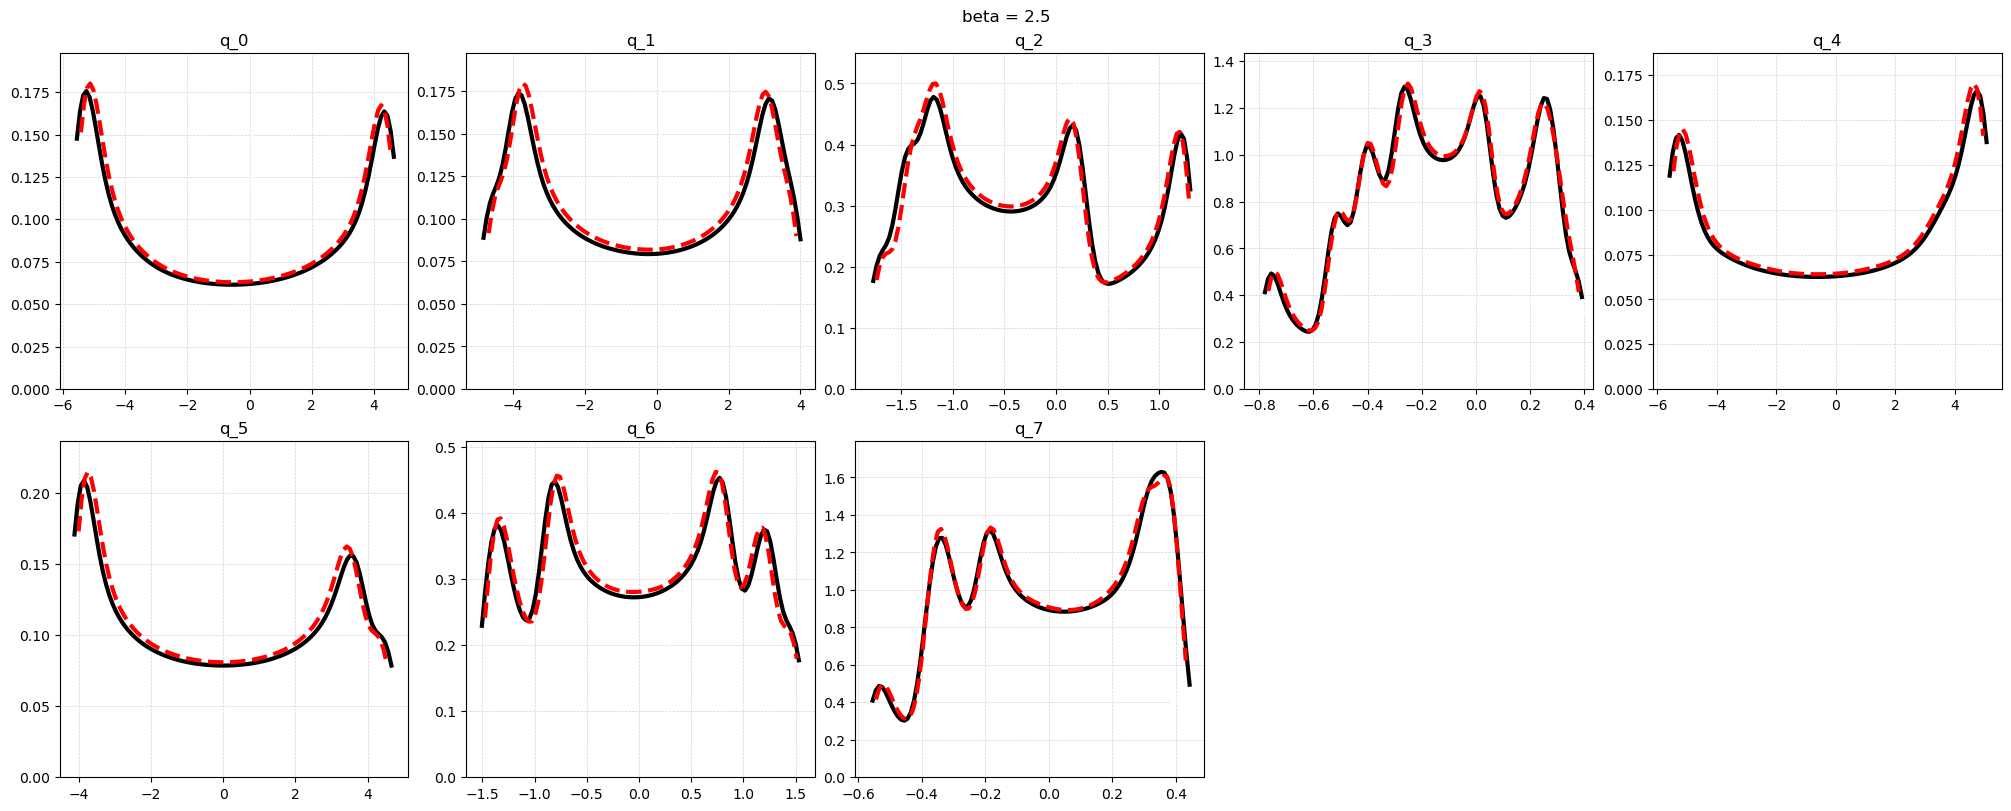

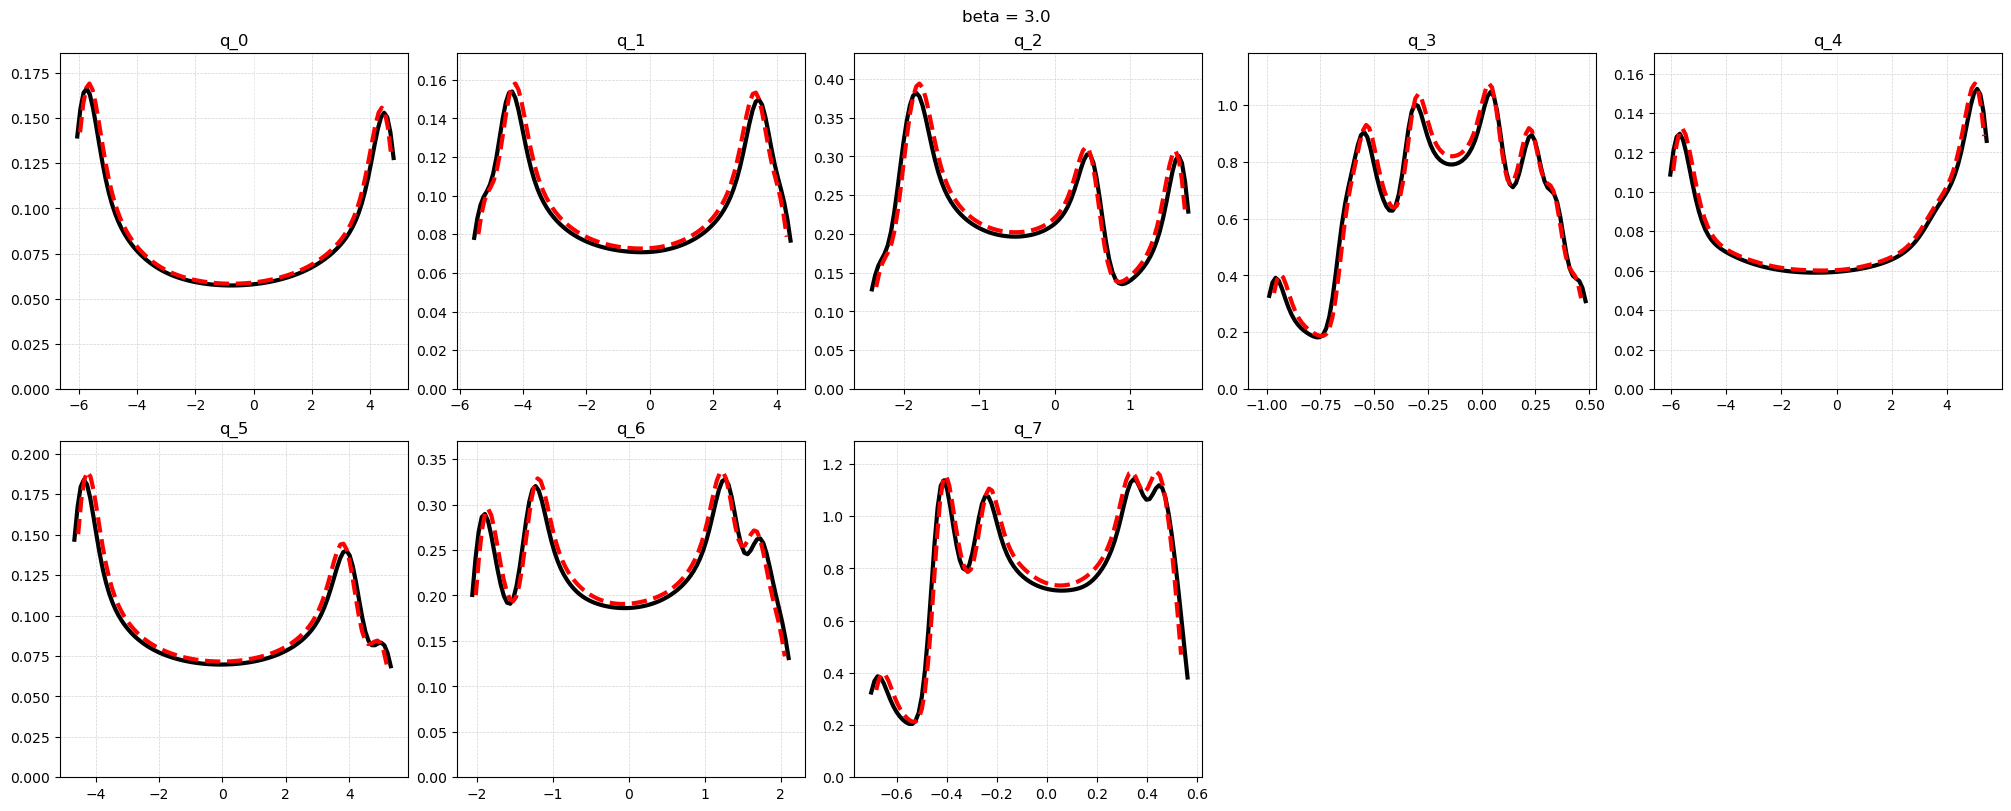

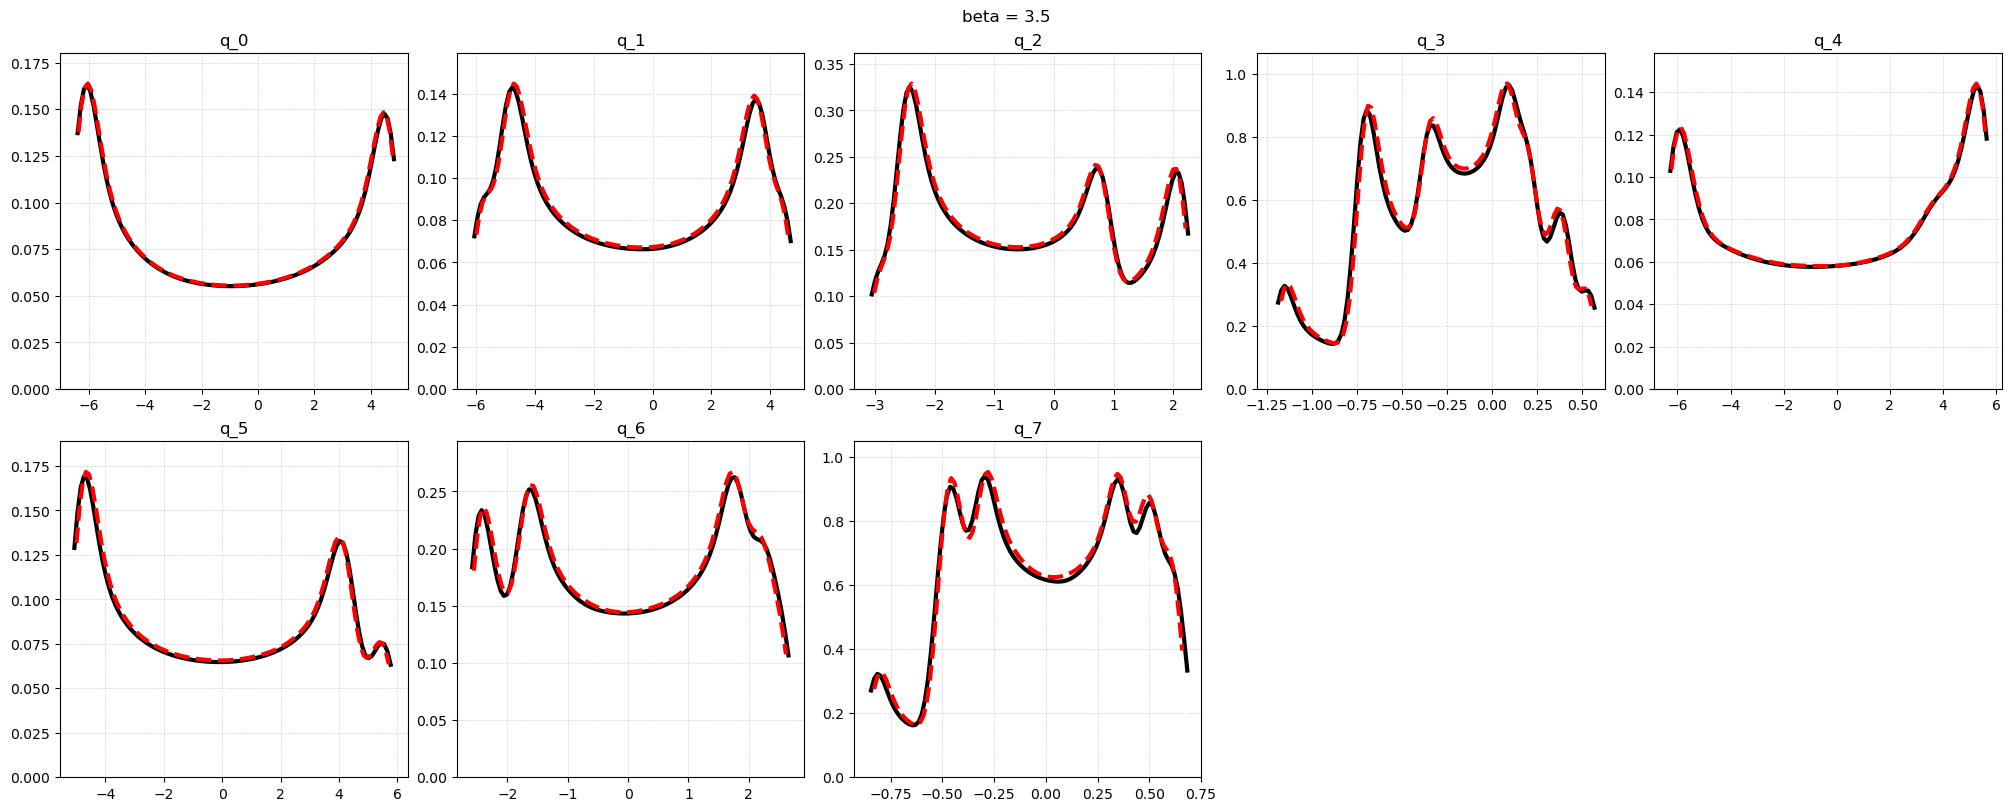

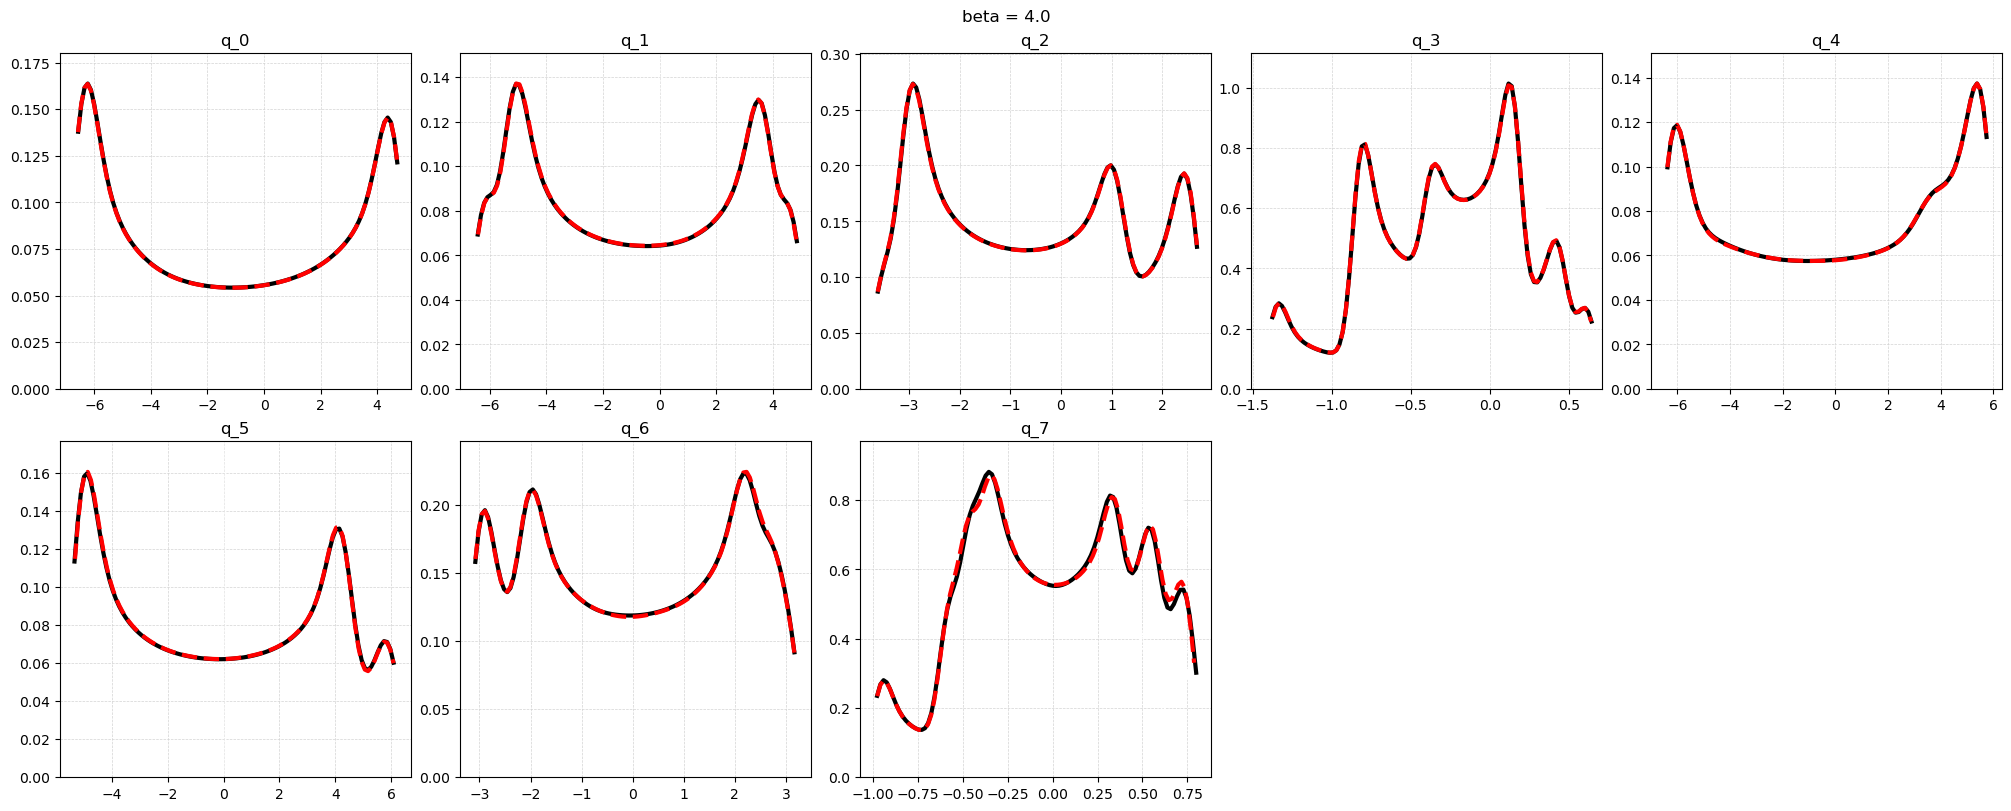

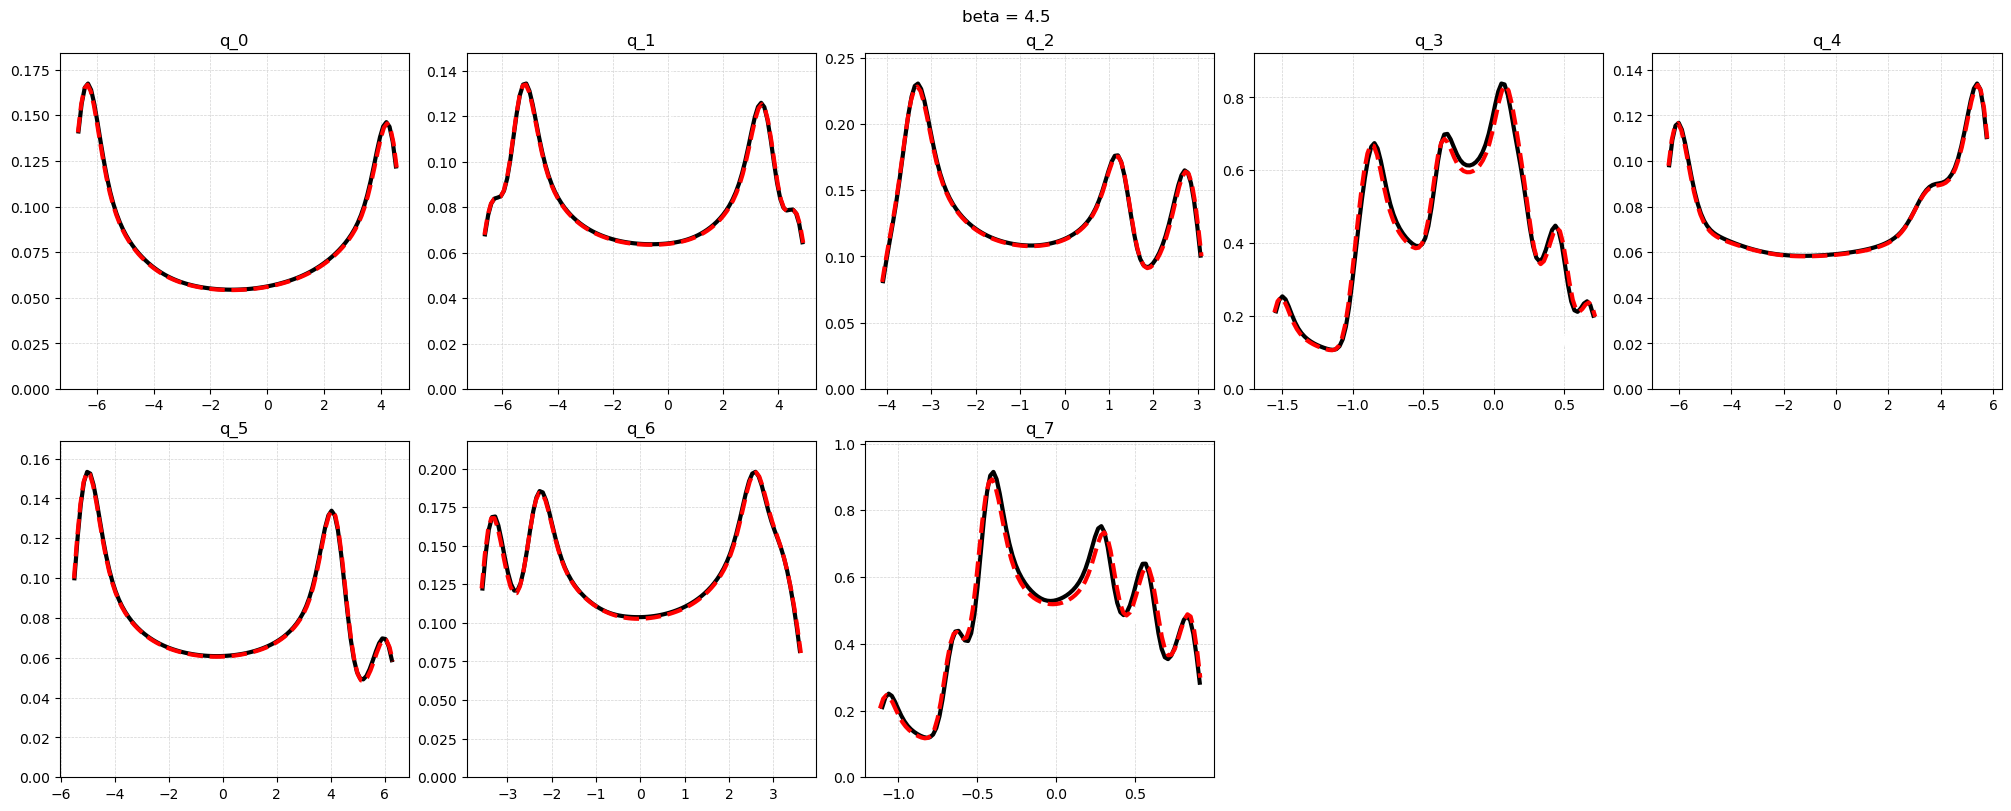

In [179]:
from scipy import stats
par = np.arange(1.0,5.0,0.5)     # new parameter
N_washout_test = 500
N_test = 100000

local_maxx=[None]*len(par)
print('prediction started')

sim_test_dict = {"t_sim_len": 1200,
            "data_dt": 1e-2,
            "dt": 1e-2,
            "t_transient_len": 0,
            "t_washout_len": 0,
            "t_train_len": 1000,
            "t_val_len": 0,
            }
plt_idx_list = [0,1,2,3,4,5,6,7]

for ind_par in range(len(par)):
    fig = plt.figure(figsize=(20,8), constrained_layout=True)
    U_init = np.zeros(dim)
    U_init[0] = 1.0
    U_washout_test = np.tile(U_init, (N_washout_test,1))
    P_test = par[ind_par]*np.ones((N_test,1))
    P_washout_test = par[ind_par]*np.ones((N_washout_test,1))
    _, Y_pred_data = my_ESN.closed_loop_with_washout(U_washout = U_washout_test, N_t = N_test-1, P_washout=P_washout_test, P = P_test)
    pred_data = Y_pred_data[20000:,:]

    if param == "beta":
        beta_test = par[ind_par]
        print("Beta:", beta_test)
        tau_test = 0.2
    elif param == "tau":
        tau_test = par[ind_par]
        print("Tau:", tau_test)
        beta_test = 1.2

    print(par[ind_par])
    beta_name = f'{beta_test:.2f}'
    beta_name = beta_name.replace(".","_")
    tau_name = f'{tau_test:.2f}'
    tau_name = tau_name.replace(".","_")
    data_path = f"data_new/rijke_kings_poly_N_g_4_beta_{beta_name}_tau_{tau_name}.h5"
    #data_path = None
    _, _, Y_data, t, _, _, _, _ = load_data_sys(beta=beta_test,tau=tau_test,N_g=N_g,**sim_test_dict, data_path=data_path)
    true_data = Y_data[20000:N_test,:]


    bin_size = 100
    lw = 3
    fs = 12
    for plt_idx in plt_idx_list:
        ax = plt.subplot(2,5,plt_idx+1)
        true_density = stats.gaussian_kde(true_data[:,plt_idx]) 
        n, x, _ = plt.hist(true_data[:,plt_idx], bins=bin_size, color='white', histtype=u'step',
                            density=True, orientation='horizontal')
        pred_density = stats.gaussian_kde(pred_data[:,plt_idx])
        n, x_pred, _ = plt.hist(pred_data[:,plt_idx], bins=bin_size, color='white',
                                histtype=u'step', density=True, orientation='horizontal')
        ax.plot(x, true_density(x), 'k', linewidth=lw, label='Reference')
        ax.plot(x_pred, pred_density(x_pred), 'r--', linewidth=lw, label='ESN')
        ax.set_title(f"q_{plt_idx}")
        ax.set_xlim(min(x)*1.1, max(x)*1.1)
        ax.set_ylim(0.0, (max(true_density(x).max(), pred_density(x_pred).max())*1.1))
        #ax.set_aspect(1./ax.get_data_ratio())
        # ax.set_yticklabels([])
        ax.grid(True, c='lightgray', linestyle='--', linewidth=0.5)
    fig.suptitle(f"beta = {par[ind_par]}")

In [121]:
# #--------prediction for a new parameter--------------------------------------------------------------------
par = np.arange(0.3,9.0,0.2)     # new parameter
N_washout_test = 500
N_test = 50000

local_maxx=[None]*len(par)
print('prediction started')
for ind_par in range(len(par)):
    U_init = np.zeros(dim)
    U_init[0] = 1.0
    U_washout_test = np.tile(U_init, (N_washout_test,1))
    P_test = par[ind_par]*np.ones((N_test,1))
    P_washout_test = par[ind_par]*np.ones((N_washout_test,1))
    _, Y_pred_data = my_ESN.closed_loop_with_washout(U_washout = U_washout_test, N_t = N_test-1, P_washout=P_washout_test, P = P_test)
    pred_data = Y_pred_data[20000:,0]

    aa = []
    aa_idx = []
    for ind_pred_data in range(len(pred_data)-2):
            
        if pred_data[ind_pred_data+2]-pred_data[ind_pred_data+1] < 0 and pred_data[ind_pred_data+1]-pred_data[ind_pred_data] > 0:
            aa = np.append(aa, pred_data[ind_pred_data+1])
            aa_idx = np.append(aa_idx, ind_pred_data)
            
    if pred_data[-2]-pred_data[-3] < 10**-3:
        aa = np.append(aa,pred_data[-2])
        aa_idx = np.append(aa_idx, ind_pred_data)
                
    local_maxx[ind_par] = aa

    #plt.figure(figsize=(15,4))
    #plt.plot(pred_data, color = 'tab:orange')
    #plt.plot(aa_idx,aa,'ro')
    #plt.title(f"beta = {par[ind_par]}")
    #plt.xlabel("time step")
    #plt.ylabel("q_0")

prediction started


In [118]:
par = np.arange(0.3,9.0,0.2)     # new parameter
local_maxx_true=[None]*len(par)
sim_test_dict = {"t_sim_len": 1200,
            "data_dt": 1e-2,
            "dt": 1e-2,
            "t_transient_len": 200,
            "t_washout_len": 0,
            "t_train_len": 500,
            "t_val_len": 0,
            }
for ind_par in range(len(par)):
    if param == "beta":
        beta_test = par[ind_par]
        print("Beta:", beta_test)
        tau_test = 0.2
    elif param == "tau":
        tau_test = par[ind_par]
        print("Tau:", tau_test)
        beta_test = 1.2

    print(par[ind_par])
    beta_name = f'{beta_test:.2f}'
    beta_name = beta_name.replace(".","_")
    tau_name = f'{tau_test:.2f}'
    tau_name = tau_name.replace(".","_")
    data_path = f"data_new/rijke_kings_poly_N_g_4_beta_{beta_name}_tau_{tau_name}.h5"
    _, _, Y_data, t, _, _, _, _ = load_data_sys(beta=beta_test,tau=tau_test,N_g=N_g,**sim_test_dict, data_path=data_path)
    true_data = Y_data[:,0]
    
    bb = []
    bb_idx = []
    for ind_true_data in range(len(true_data)-2):    
        if true_data[ind_true_data+2]-true_data[ind_true_data+1] < 0 and true_data[ind_true_data+1]-true_data[ind_true_data] > 0:
            bb = np.append(bb, true_data[ind_true_data+1])
            bb_idx = np.append(bb_idx, ind_true_data)

    # what is the point of this?        
    #if true_data[-2]-true_data[-3] < 10**-3:
    #    bb = np.append(bb,true_data[-2])
                          
    local_maxx_true[ind_par] = bb
    #plt.figure(figsize=(15,4))
    #plt.plot(true_data)
    #plt.plot(bb_idx,bb,'ro')
    #plt.title(f"beta = {par[ind_par]}")

Beta: 0.3
0.3
Beta: 0.5
0.5
Beta: 0.7
0.7
Beta: 0.9000000000000001
0.9000000000000001
Beta: 1.1
1.1
Beta: 1.3
1.3
Beta: 1.5000000000000002
1.5000000000000002
Beta: 1.7000000000000002
1.7000000000000002
Beta: 1.9000000000000001
1.9000000000000001
Beta: 2.1
2.1
Beta: 2.3
2.3
Beta: 2.5
2.5
Beta: 2.7
2.7
Beta: 2.9
2.9
Beta: 3.1
3.1
Beta: 3.3
3.3
Beta: 3.5
3.5
Beta: 3.7
3.7
Beta: 3.9
3.9
Beta: 4.1000000000000005
4.1000000000000005
Beta: 4.3
4.3
Beta: 4.5
4.5
Beta: 4.7
4.7
Beta: 4.9
4.9
Beta: 5.1000000000000005
5.1000000000000005
Beta: 5.3
5.3
Beta: 5.5
5.5
Beta: 5.7
5.7
Beta: 5.9
5.9
Beta: 6.1000000000000005
6.1000000000000005
Beta: 6.3
6.3
Beta: 6.5
6.5
Beta: 6.7
6.7
Beta: 6.9
6.9
Beta: 7.1000000000000005
7.1000000000000005
Beta: 7.3
7.3
Beta: 7.5
7.5
Beta: 7.7
7.7
Beta: 7.9
7.9
Beta: 8.100000000000001
8.100000000000001
Beta: 8.3
8.3
Beta: 8.500000000000002
8.500000000000002
Beta: 8.700000000000001
8.700000000000001
Beta: 8.9
8.9


Text(0.5, 1.0, 'True')

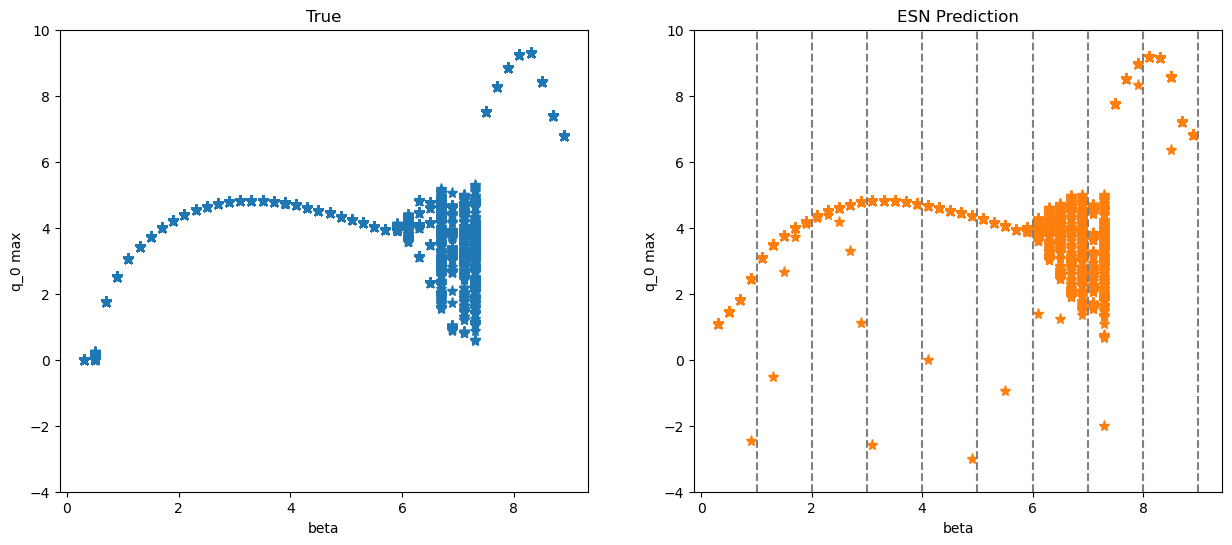

In [123]:
# bifurcation diagram
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

for ind_par in range(len(par)):
   plot_local_maxx=local_maxx[ind_par]  
   ax[1].plot(par[ind_par]*np.ones(len(plot_local_maxx)), plot_local_maxx, color='tab:orange', marker='*', linestyle='None',
                                       linewidth=3, markersize=8)
plt.vlines(np.array(p_list)[0:9:1], ymin=-4, ymax=10, color = "grey", linestyles='dashed')
ax[1].set_ylim([-4,10])
ax[1].set_xlabel("beta")
ax[1].set_ylabel("q_0 max")  
ax[1].set_title("ESN Prediction")

for ind_par in range(len(par)): 
    plot_local_maxx=local_maxx_true[ind_par]  
    ax[0].plot(par[ind_par]*np.ones(len(plot_local_maxx)), plot_local_maxx, color='tab:blue', marker='*', linestyle='None',
                                        linewidth=3, markersize=8)
ax[0].set_ylim([-4,10]) 
ax[0].set_xlabel("beta")
ax[0].set_ylabel("q_0 max")   
ax[0].set_title("True")


In [120]:
# bifurcation diagram
for ind_par in range(len(par)):
   plot_local_maxx=local_maxx[ind_par]  
   plt.plot(par[ind_par]*np.ones(len(plot_local_maxx)), plot_local_maxx, color='tab:orange', marker='*', linestyle='None',
                                       linewidth=3, markersize=8)


TypeError: object of type 'NoneType' has no len()

In [6]:
def run_true_grad(my_rijke, t_bar, y_bar, data_dt, dt):
    # direct problem
    #dir0 = np.zeros(2*my_rijke.N_dim+2)
    #dir = odeint(my_rijke.direct_ode,dir0,t_bar,args=(t_bar,1/data_dt,y_bar),tfirst= True)
    #dJ_dp_dir = 1/t_bar[-1]*dir[-1,-2]
    dJ_dp_dir = 0
    
    # adjoint problem
    adjT = np.zeros(my_rijke.N_dim+2)
    adj = odeint(my_rijke.adjoint_ode,adjT,np.flip(t_bar),args =(t_bar,1/data_dt,y_bar),tfirst= True)
    dJ_dp_adj  = 1/t_bar[-1]*adj[-1,-2:]
    
    # plt.figure()
    # plt.plot(t_bar[1:],1/t_bar[1:]*adj[1:,-2])
    # plt.xlabel("t")
    # plt.title("dJ/dbeta")
    # plt.figure()
    # plt.plot(t_bar[1:],1/t_bar[1:]*adj[1:,-1])
    # plt.title("dJ/dtau")
    # dJ_dp_adj = 0
    
    # Calculate numerically
    # Find perturbed solutions (in beta)
    dJ_dp_num = np.zeros((2,))

    J = 1/4*np.mean(np.sum(y_bar[1:,0:2*my_rijke.N_g]**2, axis = 1))
    
    # h = 1e-5 # perturbation on the parameter
    # # left solution with beta = beta-h
    # my_rijke_beta_left = Rijke(N_g=my_rijke.N_g,N_c=my_rijke.N_c,c_1=0.1,c_2=0.06,beta=my_rijke.beta-h,x_f=my_rijke.x_f,tau=my_rijke.tau,
    #                  heat_law="kings_poly",damping="modal")

    # y_bar_beta_left = odeint(my_rijke_beta_left.ode,y_bar[0,:],t_bar,tfirst = True)
    # J_beta_left = 1/4*np.mean(np.sum(y_bar_beta_left[1:,0:2*my_rijke_beta_left.N_g]**2, axis = 1))
        
    # # right solution with beta = beta+h
    # my_rijke_beta_right = Rijke(N_g=my_rijke.N_g,N_c=my_rijke.N_c,c_1=0.1,c_2=0.06,beta=my_rijke.beta+h,x_f=my_rijke.x_f,tau=my_rijke.tau,
    #                  heat_law="kings_poly",damping="modal")
    
    # y_bar_beta_right = odeint(my_rijke_beta_right.ode,y_bar[0,:],t_bar,tfirst = True)
    # J_beta_right = 1/4*np.mean(np.sum(y_bar_beta_right[1:,0:2*my_rijke_beta_right.N_g]**2, axis = 1))
    # dJ_dp_num[0] = (J_beta_right-J_beta_left)/(2*h)

    h_tau = 1e-2
    # left solution with tau = tau-h
    my_rijke_tau_left = Rijke(N_g=my_rijke.N_g,N_c=my_rijke.N_c,c_1=0.1,c_2=0.06,beta=my_rijke.beta,x_f=my_rijke.x_f,tau=my_rijke.tau-h_tau,
                     heat_law="kings_poly",damping="modal")

    y_bar_tau_left = odeint(my_rijke_tau_left.ode,y_bar[0,:],t_bar,tfirst = True)
    J_tau_left = 1/4*np.mean(np.sum(y_bar_tau_left[1:,0:2*my_rijke_tau_left.N_g]**2, axis = 1))
        
    # # right solution with tau = tau+h
    # my_rijke_tau_right = Rijke(N_g=my_rijke.N_g,N_c=my_rijke.N_c,c_1=0.1,c_2=0.06,beta=my_rijke.beta,x_f=my_rijke.x_f,tau=my_rijke.tau+h_tau,
    #                  heat_law="kings_poly",damping="modal")
    
    # y_bar_tau_right = odeint(my_rijke_tau_right.ode,y_bar[0,:],t_bar,tfirst = True)
    # J_tau_right = 1/4*np.mean(np.sum(y_bar_tau_right[1:,0:2*my_rijke_tau_right.N_g]**2, axis = 1))
    dJ_dp_num[1] = (J-J_tau_left)/(h_tau)


    print("J = ", J)
    # print("J beta left = ",J_beta_left)
    # print("J beta right = ",J_beta_right)
    print("J tau left = ",J_tau_left)
    # print("J tau right = ",J_tau_right)

    #print("dJ/dp direct = ", dJ_dp_dir)
    print("dJ/dp adjoint = ", dJ_dp_adj)
    print("dJ/dp numerical = ", dJ_dp_num)

    return dJ_dp_dir,dJ_dp_adj,dJ_dp_num

def run_esn_grad(my_ESN, N, X_pred_grad, Y_pred_grad, P_grad, N_tau):
    # OBJECTIVE SQUARED L2 OF OUTPUT STATES (ACOUSTIC ENERGY)
    # calculate gradient for a timeseries, direct method
    # time averaged objective
    # q = np.zeros((my_ESN.N_reservoir, my_ESN.N_param_dim))
    # q_prev = np.zeros((my_ESN.N_reservoir, my_ESN.N_param_dim))
    dJ_dp_dir = np.zeros(my_ESN.N_param_dim)
    # for i in np.arange(1,N):
    #     q = my_ESN.drdp(X_pred_grad[i,:]).toarray()+np.dot(my_ESN.jac(X_pred_grad[i,:]).toarray(),q_prev)
    #     q_prev = q 
    #     X_pred_aug = np.hstack((X_pred_grad[i,:], my_ESN.b_out))
    #     dJ_dr = (1/N)*1/2*np.dot(np.dot(X_pred_aug,my_ESN.W_out),my_ESN.W_out[: my_ESN.N_reservoir, :].T)
    #     #dJ_dr2 = (1/N)*2*np.einsum("r, rb, bn -> n", X_pred_aug,my_ESN.W_out,my_ESN.W_out[: my_ESN.N_reservoir, :].T)
    #     dJ_dp_dir += np.dot(dJ_dr,q)
# 
    # # calculate gradient for a timeseries, adjoint method
    # time averaged objective
    # X_pred_aug = np.hstack((X_pred_grad[N - 1, :], my_ESN.b_out))
    # v_prev = (
    #     (1 / N)
    #     * 1
    #     / 2
    #     * np.dot(
    #         np.dot(X_pred_aug, my_ESN.W_out[:,:20]), my_ESN.W_out[: my_ESN.N_reservoir, :20].T
    #     ).T
    # )
    dJ_dp_adj = np.zeros(my_ESN.N_param_dim)
    # for i in np.arange(N - 1, 0, -1):
    #     dJ_dp_adj += np.dot(my_ESN.drdp(X_pred_grad[i, :]).toarray().T, v_prev)
    #     X_pred_aug = np.hstack((X_pred_grad[i - 1, :], my_ESN.b_out))
    #     dJ_dr = (
    #         (1 / N)
    #         * 1
    #         / 2
    #         * np.dot(
    #             np.dot(X_pred_aug, my_ESN.W_out[:,:20]),
    #             my_ESN.W_out[: my_ESN.N_reservoir, :20].T,
    #         ).T
    #     )
    #     v = np.dot(my_ESN.jac(X_pred_grad[i, :]).T, v_prev) + dJ_dr
    #     v_prev = v

    # calculate gradient for a timeseries, numerical method
    # time averaged objective 
    h = 1e-5
    J = 1/4*np.mean(np.sum(Y_pred_grad[:,0:2*N_g]**2, axis = 1))
    
    dJ_dp_num = np.zeros((my_ESN.N_param_dim))
    for i in range(my_ESN.N_param_dim):
        P_left = P_grad.copy()
        P_left[:,i] -= h
        P_right = P_grad.copy()
        P_right[:,i] += h
        _, Y_left = my_ESN.closed_loop(X_pred_grad[0:N_tau+1,:], N-1, P_left)
        _, Y_right =  my_ESN.closed_loop(X_pred_grad[0:N_tau+1,:], N-1, P_right)
        J_left = 1/4*np.mean(np.sum(Y_left[:,0:2*N_g]**2, axis = 1))
        J_right = 1/4*np.mean(np.sum(Y_right[:,0:2*N_g]**2, axis = 1))
        dJ_dp_num[i] = (J_right-J_left)/(2*h)
    
    print("J ESN = ", J)
    print("J left ESN = ",J_left)
    print("J right ESN = ",J_right)

    #print("dJ/dp direct ESN = ", dJ_dp_dir)
    print("dJ/dp adjoint ESN = ", dJ_dp_adj)
    print("dJ/dp numerical ESN = ", dJ_dp_num)
    return dJ_dp_dir,dJ_dp_adj,dJ_dp_num

In [19]:
def run_rijke_esn_grad(my_ESN, N, X_pred_grad, Y_pred_grad, P_grad, X_tau, N_tau):
    XX = np.vstack((X_tau[-N_tau-1:-1,:],X_pred_grad))
    # OBJECTIVE SQUARED L2 OF OUTPUT STATES (ACOUSTIC ENERGY)
    # calculate gradient for a timeseries, direct method
    # time averaged objective
    q = np.zeros((N+1, my_ESN.N_reservoir, my_ESN.N_param_dim+1))
    dJ_dp_dir = np.zeros(my_ESN.N_param_dim+1)
    # # i = 1,..,N
    for i in np.arange(1,N+1):
        dr_dbeta = my_ESN.drdp(X_pred_grad[i,:],X_pred_grad[i-1,:]).toarray()

        # get tau sensitivity via finite difference
        XX_aug_left = np.hstack((XX[i,:], my_ESN.b_out))
        XX_aug = np.hstack((XX[i-1,:], my_ESN.b_out))
        eta_tau_left = np.dot(XX_aug_left, my_ESN.W_out)[0 : my_ESN.N_g]
        eta_tau = np.dot(XX_aug, my_ESN.W_out)[0 : my_ESN.N_g]

        u_f_tau_left = Rijke.toVelocity(
            N_g=my_ESN.N_g, eta=eta_tau_left, x=np.array([my_ESN.x_f])
        )
        u_f_tau = Rijke.toVelocity(
            N_g=my_ESN.N_g, eta=eta_tau, x=np.array([my_ESN.x_f])
        )
        
        du_f_tau_dtau = (u_f_tau-u_f_tau_left)/my_ESN.dt

        drdu_f_tau = my_ESN.drdu_f_tau(X_pred_grad[i,:],X_pred_grad[i-1,:],u_f_tau)

        dr_dtau = drdu_f_tau*du_f_tau_dtau

        drdp = np.hstack((dr_dbeta, dr_dtau))

        if i <= N_tau:
            q[i] = (drdp
                    +np.dot(my_ESN.jac(X_pred_grad[i,:],X_pred_grad[i-1,:]),q[i-1]))
        elif i > N_tau:
            q[i] = (drdp
                    +np.dot(my_ESN.jac(X_pred_grad[i,:],X_pred_grad[i-1,:]),q[i-1])
                    +np.dot(my_ESN.jac_tau(X_pred_grad[i,:],X_pred_grad[i-1,:],u_f_tau),q[i-N_tau-1]))
            
        
        X_pred_aug = np.hstack((X_pred_grad[i,:], my_ESN.b_out))
        dJ_dr = (1/N)*1/2*np.dot(np.dot(X_pred_aug,my_ESN.W_out),my_ESN.W_out[: my_ESN.N_reservoir, :].T)
        dJ_dp_dir += np.dot(dJ_dr,q[i])

    # calculate gradient for a timeseries, adjoint method
    # time averaged objective
    v = np.zeros((N+1, my_ESN.N_reservoir))
    dJ_dp_adj = np.zeros(my_ESN.N_param_dim+1)
    
    X_pred_aug = np.hstack((X_pred_grad[N, :], my_ESN.b_out))
    v[N] = (
        (1 / N)
        * 1
        / 2
        * np.dot(
            np.dot(X_pred_aug, my_ESN.W_out), my_ESN.W_out[: my_ESN.N_reservoir, :].T
        ).T
    )
    
    for i in np.arange(N, 0, -1):
        dr_dbeta = my_ESN.drdp(X_pred_grad[i,:],X_pred_grad[i-1,:]).toarray()

        # get tau sensitivity via finite difference
        XX_aug_left = np.hstack((XX[i,:], my_ESN.b_out))
        XX_aug = np.hstack((XX[i-1,:], my_ESN.b_out))
        eta_tau_left = np.dot(XX_aug_left, my_ESN.W_out)[0 : my_ESN.N_g]
        eta_tau = np.dot(XX_aug, my_ESN.W_out)[0 : my_ESN.N_g]

        u_f_tau_left = Rijke.toVelocity(
            N_g=my_ESN.N_g, eta=eta_tau_left, x=np.array([my_ESN.x_f])
        )
        u_f_tau = Rijke.toVelocity(
            N_g=my_ESN.N_g, eta=eta_tau, x=np.array([my_ESN.x_f])
        )
        
        du_f_tau_dtau = (u_f_tau-u_f_tau_left)/my_ESN.dt

        drdu_f_tau = my_ESN.drdu_f_tau(X_pred_grad[i,:],X_pred_grad[i-1,:],u_f_tau)

        dr_dtau = drdu_f_tau*du_f_tau_dtau

        drdp = np.hstack((dr_dbeta, dr_dtau))
 
        dJ_dp_adj += np.dot(v[i], drdp)
        X_pred_aug = np.hstack((X_pred_grad[i-1, :], my_ESN.b_out))
        dJ_dr = (
            (1 / N)
            * 1
            / 2
            * np.dot(
                np.dot(X_pred_aug, my_ESN.W_out),
                my_ESN.W_out[: my_ESN.N_reservoir, :].T,
            ).T
        )
        if i <= N-N_tau:
            eta_tau_future = np.dot(X_pred_grad[i-1,:], my_ESN.W_out)[0 : my_ESN.N_g]
            u_f_tau_future = Rijke.toVelocity(N_g=my_ESN.N_g, eta=eta_tau_future, x=np.array([my_ESN.x_f]))

            v[i-1] = (np.dot(my_ESN.jac(X_pred_grad[i, :],X_pred_grad[i-1, :]).T,v[i]) 
                    +np.dot(my_ESN.jac_tau(X_pred_grad[i+N_tau,:],X_pred_grad[i+N_tau-1,:],u_f_tau_future).T,v[i+N_tau])
                    +dJ_dr)
        else:
            v[i-1] = (np.dot(my_ESN.jac(X_pred_grad[i, :],X_pred_grad[i-1, :]).T,v[i]) 
                    +dJ_dr)

    # calculate gradient for a timeseries, numerical method
    # time averaged objective 
    h = 1e-5
    J = 1/4*np.mean(np.sum(Y_pred_grad[1:,0:2*my_ESN.N_g]**2, axis = 1))

    dJ_dp_num = np.zeros((my_ESN.N_param_dim+1))
    for i in range(my_ESN.N_param_dim):
        P_left = P_grad.copy()
        P_left[:,i] -= h
        P_right = P_grad.copy()
        P_right[:,i] += h
        _, Y_left = my_ESN.closed_loop(X_tau[-my_ESN.N_tau-1:,:], N, P_left)
        _, Y_right =  my_ESN.closed_loop(X_tau[-my_ESN.N_tau-1:,:], N, P_right)
        J_left = 1/4*np.mean(np.sum(Y_left[1:,0:2*my_ESN.N_g]**2, axis = 1))
        J_right = 1/4*np.mean(np.sum(Y_right[1:,0:2*my_ESN.N_g]**2, axis = 1))
        dJ_dp_num[i] = (J_right-J_left)/(2*h)

    orig_tau = my_ESN.tau
    h_tau = my_ESN.dt
    my_ESN.tau = orig_tau-h_tau
    _, Y_tau_left = my_ESN.closed_loop(X_tau[-my_ESN.N_tau-1:,:], N, P_grad)
    # my_ESN.tau = orig_tau+h_tau
    # _, Y_tau_right =  my_ESN.closed_loop(X_tau[0:my_ESN.N_tau,:], N, P_grad)
    J_tau_left = 1/4*np.mean(np.sum(Y_tau_left[1:,0:2*my_ESN.N_g]**2, axis = 1))
    # J_tau_right = 1/4*np.mean(np.sum(Y_tau_right[1:,0:2*my_ESN.N_g]**2, axis = 1))
    dJ_dp_num[-1] = (J-J_tau_left)/(h_tau)

    print("J ESN = ", J)
    # print("J left ESN = ",J_left)
    # print("J right ESN = ",J_right)
    print("J tau left ESN = ",J_tau_left)
    # print("J tau right ESN = ",J_tau_right)

    print("dJ/dp direct ESN = ", dJ_dp_dir)
    print("dJ/dp adjoint ESN = ", dJ_dp_adj)
    print("dJ/dp numerical ESN = ", dJ_dp_num)
    return dJ_dp_dir,dJ_dp_adj,dJ_dp_num

In [8]:
# Taylor test
def taylor_test(my_ESN,X_pred_grad,P_grad,N,X_tau,N_tau,dJ_dp):
    epsilon_list = [1,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]
    X, Y =  my_ESN.closed_loop(X_tau, N, P_grad)
    J_0 = 1/4*np.mean(np.sum(Y[1:,0:2*N_g]**2, axis = 1))
    taylor = np.zeros((len(epsilon_list),my_ESN.N_param_dim))
    j_1_j_0_eps = np.zeros((len(epsilon_list),my_ESN.N_param_dim))
    for epsilon_idx, epsilon in enumerate(epsilon_list):
        for i in range(my_ESN.N_param_dim):
            P_right = P_grad.copy()
            P_right[:,i] += epsilon
            X_right, Y_right =  my_ESN.closed_loop(X_tau, N, P_right)
            J_1 = 1/4*np.mean(np.sum(Y_right[1:,0:2*N_g]**2, axis = 1))
            j_1_j_0_eps[epsilon_idx, i] = (J_1-J_0)/epsilon
            taylor[epsilon_idx, i] = j_1_j_0_eps[epsilon_idx, i]-dJ_dp
            print("J_1 - J_0 = ",J_1-J_0)
            print("(J_1 - J_0)/epsilon = ",(J_1-J_0)/epsilon)
            print("(J_1 - J_0)/epsilon - dJ/dp = ",(J_1-J_0)/epsilon-dJ_dp)
            print(taylor[epsilon_idx, i])
    plt.plot(epsilon_list,np.abs(taylor[:,0]),'o-')
    # plt.plot(epsilon_list,np.abs(j_1_j_0_eps[:,0]-j_1_j_0_eps[-1,0]),'o-')
    plt.xlabel("log10(epsilon)")
    plt.ylabel("|log10((J1-J0-epsilon*dJ/dp)/epsilon)|")
    plt.xscale("log")
    plt.yscale("log")
    plt.title("Taylor test")
    plt.show()

In [20]:
my_p_list = np.arange(0.05,0.35,0.05)
my_p_list = np.array([0.05])
n_esns = 1
dJ_dp_dir_true = np.zeros((len(my_p_list),2))
dJ_dp_adj_true = np.zeros((len(my_p_list),2))
dJ_dp_num_true = np.zeros((len(my_p_list),2))
dJ_dp_dir_esn = np.zeros((n_esns,len(my_p_list),2))
dJ_dp_adj_esn = np.zeros((n_esns,len(my_p_list),2))
dJ_dp_num_esn = np.zeros((n_esns,len(my_p_list),2))
J_bar = np.zeros(len(my_p_list))
J_esn = np.zeros(len(my_p_list))

sim_dict3 = {"t_sim_len": 220,
            "data_dt": 1e-3,
            "dt": 1e-2,
            "t_transient_len": 200,
            "t_washout_len": 10,
            "t_train_len": 10,
            "t_val_len": 0,
            }
param = "tau"
x_f_grad = 0.2
my_ESN.x_f = x_f_grad
for esn_idx in range(n_esns):
    # my_ESN = RijkeESN(reservoir_size = 1800, 
    #         N_g = N_g,
    #         u_f_order = u_f_order,
    #         x_f = 0.2,
    #         tau = 0.2,
    #         dt = 0.01,
    #         parameter_dimension = 1, 
    #         reservoir_connectivity = 3, 
    #         spectral_radius = 0.1,    
    #         input_scaling = 0.08256408,                                       
    #         u_f_scaling = 1.36869035, 
    #         leak_factor = 0.20453469,
    #         parameter_normalization=[np.array([-2.33530715,]),np.array([1.56908385])],
    #         input_bias = np.array([]),
    #         output_bias = np.array([]),
    #         input_normalization = scale, 
    #         r2_mode=False,
    #         input_seeds=[1,2,3],
    #         reservoir_seeds=[4,5],
    #         input_weights_mode="sparse_grouped_rijke_dense",
    #         input_only_mode=True,)
    # my_ESN.train(U_washout_train, U_train, Y_train, tikhonov = 1e-3, P_washout=P_washout_train, P_train=P_train, train_idx_list=[0,1,2,3,4,5,6,7,8])

    for p_idx, my_p in enumerate(my_p_list):
        if param == "beta":
            beta_grad = my_p
            print("Beta:", beta_grad)

            tau_grad = 0.2
            my_ESN.tau = tau_grad
        elif param == "tau":
            tau_grad = my_p
            print("Tau:", tau_grad)
            my_ESN.tau = tau_grad

            beta_grad= 2.5

        beta_name = f'{beta_grad:.2f}'
        beta_name = beta_name.replace(".","_")
        tau_name = f'{tau_grad:.2f}'
        tau_name = tau_name.replace(".","_")
        data_path = f"data_new/rijke_kings_poly_N_g_4_beta_{beta_name}_tau_{tau_name}.h5"
        if not Path(data_path).exists():
            data_path = None
        data_path = None
        my_rijke = Rijke(N_g=N_g,N_c=10,c_1=0.1,c_2=0.06,beta=beta_grad,x_f=x_f_grad,tau=tau_grad,
                heat_law="kings_poly",damping="modal")
        y_sim, U_sim, t_sim = run_rijke_sim(beta_grad,tau_grad,N_g,
                                            sim_dict3["t_sim_len"],sim_dict3["data_dt"], data_path = data_path, u_f_order=u_f_order, x_f = x_f_grad)

        U_washout, U_grad, Y_grad, t_grad, _, _, _, _ = create_dataset(U_sim,t_sim,
                    sim_dict3["dt"],
                    sim_dict3["t_transient_len"],
                    sim_dict3["t_washout_len"],
                    sim_dict3["t_train_len"],
                    sim_dict3["t_val_len"],
                    u_f_order=u_f_order)
        
        J_bar[p_idx] = 1/4*np.mean(np.sum(Y_grad[:,0:2*my_rijke.N_g]**2, axis = 1))

        print("J_true = ", J_bar[p_idx])
        if data_path is None:
            N_transient = int(sim_dict3["t_transient_len"]/sim_dict3["data_dt"])
            y_bar = y_sim[N_transient:,:]
            t_bar = t_sim[N_transient:]

            N_washout = int(sim_dict3["t_washout_len"]/sim_dict3["data_dt"])
            y_bar = y_bar[N_washout:,:]
            t_bar = t_bar[N_washout:]-t_bar[N_washout]

            N_train = int(sim_dict3["t_train_len"]/sim_dict3["data_dt"])
            y_bar = y_bar[:N_train,:]
            t_bar = t_bar[:N_train]
            dJ_dp_dir_true[p_idx],dJ_dp_adj_true[p_idx],dJ_dp_num_true[p_idx] = run_true_grad(my_rijke, t_bar, y_bar, sim_dict3["data_dt"], sim_dict3["dt"])
        else:
            data_dict = pp.read_h5(data_path)
            dJ_dp_adj_true[p_idx] = [data_dict["dJ_dbeta"],data_dict["dJ_dtau"]]
            print("dJ/dp true = ", dJ_dp_adj_true[p_idx])

        N = int(sim_dict3["t_train_len"]/sim_dict3["dt"])
        P_grad = beta_grad*np.ones((N,1))
        P_washout = beta_grad*np.ones((len(U_washout),1))
        N_tau = int(tau_grad/sim_dict3["dt"])
        # Wash-out phase to get rid of the effects of reservoir states initialised as zero
        # initialise the reservoir states before washout
        x0_washout = np.zeros(my_ESN.N_reservoir)

        # let the ESN run in open-loop for the wash-out
        # get the initial reservoir to start the actual open/closed-loop,
        # which is the last reservoir state

        # X_tau = my_ESN.open_loop(x0=x0_washout, U=U_washout, P=P_washout)[
        #     -my_ESN.N_tau - 1 :, :
        # ]

        X_tau = my_ESN.open_loop(x0=x0_washout, U=U_washout, P=P_washout)
        P_grad = np.vstack((P_washout[-my_ESN.N_tau - 1 :, :], P_grad))
        X_pred_grad, Y_pred_grad = my_ESN.closed_loop(X_tau[-my_ESN.N_tau - 1 :, :], N_t=N, P=P_grad)
        J_esn[p_idx] = 1/4*np.mean(np.sum(Y_pred_grad[1:,0:2*my_rijke.N_g]**2, axis = 1))
        _,dJ_dp_adj_esn[esn_idx][p_idx],dJ_dp_num_esn[esn_idx][p_idx] = run_rijke_esn_grad(my_ESN, N, X_pred_grad, Y_pred_grad, P_grad, 
                                                                                           X_tau = X_tau, N_tau = N_tau)  

Tau: 0.05
J_true =  1.990060320151998
J =  1.9900561450528576
J tau left =  1.7798191293952252
dJ/dp adjoint =  [ 0.67567079 22.04427749]
dJ/dp numerical =  [ 0.         21.02370157]
J ESN =  1.9868003140175106
J tau left ESN =  1.774074381017437
dJ/dp direct ESN =  [-8.29096295 22.31118337]
dJ/dp adjoint ESN =  [-8.29096295 22.31118337]
dJ/dp numerical ESN =  [-8.2909619 21.2725933]


J_1 - J_0 =  5.831047361872879
(J_1 - J_0)/epsilon =  5.831047361872879
(J_1 - J_0)/epsilon - dJ/dp =  1.4223010959922462
1.4223010959922462
J_1 - J_0 =  0.45599436143338057
(J_1 - J_0)/epsilon =  4.559943614333806
(J_1 - J_0)/epsilon - dJ/dp =  0.1511973484531728
0.1511973484531728
J_1 - J_0 =  0.0442382984547649
(J_1 - J_0)/epsilon =  4.42382984547649
(J_1 - J_0)/epsilon - dJ/dp =  0.015083579595857266
0.015083579595857266
J_1 - J_0 =  0.00441025212903412
(J_1 - J_0)/epsilon =  4.41025212903412
(J_1 - J_0)/epsilon - dJ/dp =  0.001505863153487219
0.001505863153487219
J_1 - J_0 =  0.0004408896824497077
(J_1 - J_0)/epsilon =  4.408896824497077
(J_1 - J_0)/epsilon - dJ/dp =  0.00015055861644430735
0.00015055861644430735
J_1 - J_0 =  4.408761320906507e-05
(J_1 - J_0)/epsilon =  4.408761320906507
(J_1 - J_0)/epsilon - dJ/dp =  1.5055025873955685e-05
1.5055025873955685e-05
J_1 - J_0 =  4.408747775741517e-06
(J_1 - J_0)/epsilon =  4.408747775741517
(J_1 - J_0)/epsilon - dJ/dp =  1.5098608843

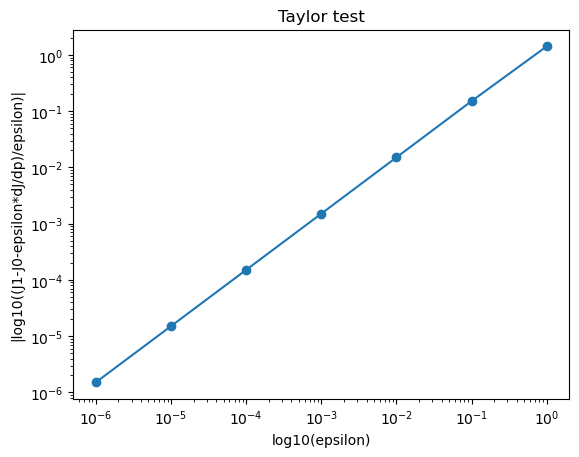

In [72]:
taylor_test(my_ESN,X_pred_grad,P_grad,N,X_tau,N_tau,dJ_dp_adj_esn[0][0])

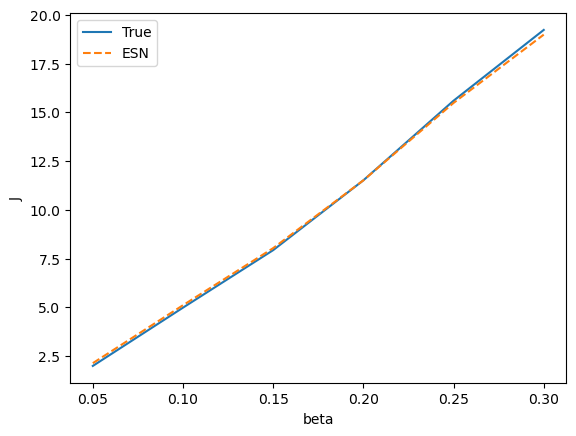

In [73]:
plt.plot(my_p_list, J_bar)
plt.plot(my_p_list, J_esn,'--')
plt.xlabel("beta")
plt.ylabel("J")
plt.legend(["True","ESN"])

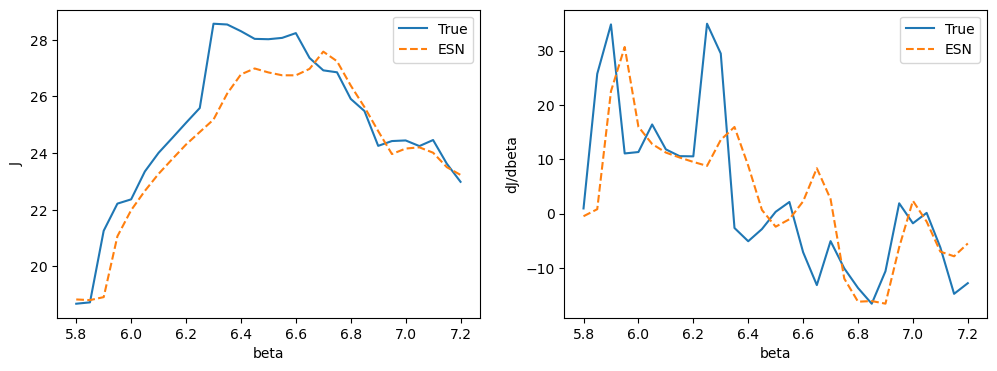

In [217]:
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.plot(my_p_list, J_bar)
plt.plot(my_p_list, J_esn,'--')
plt.xlabel("beta")
plt.ylabel("J")
plt.legend(["True","ESN"])

plt.subplot(1,2,2)
plt.plot(my_p_list, np.gradient(J_bar, my_p_list[1]-my_p_list[0]))
plt.plot(my_p_list, np.gradient(J_esn, my_p_list[1]-my_p_list[0]),'--')
plt.xlabel("beta")
plt.ylabel("dJ/dbeta")
plt.legend(["True","ESN"])

In [54]:
dJ_dp_num_true

array([[ 0.        , 56.246696  ],
       [ 0.        , 61.27553402],
       [ 0.        ,  0.        ],
       [ 0.        , 56.48516422],
       [ 0.        , 59.39646737],
       [ 0.        , 65.63036219],
       [ 0.        , 72.53057542],
       [ 0.        ,  0.        ],
       [ 0.        , 81.33202184],
       [ 0.        , 80.33115776],
       [ 0.        , 76.46332781],
       [ 0.        , 69.67096598],
       [ 0.        ,  0.        ]])

In [51]:
my_p_list

array([0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 , 0.22, 0.24, 0.26,
       0.28, 0.3 ])

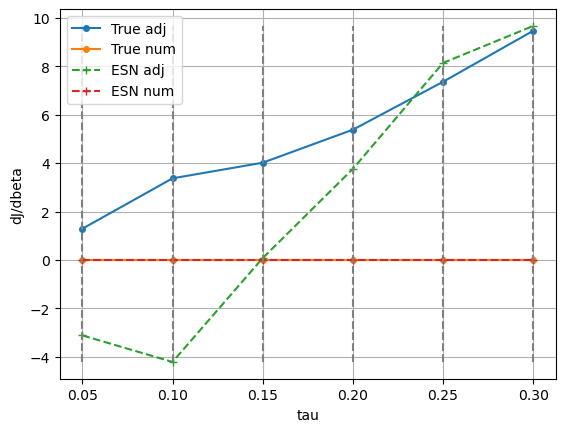

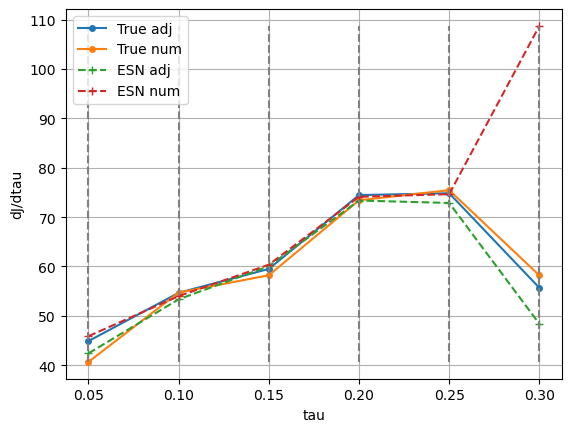

In [52]:
dJ_dp_num_esn_mean = np.mean(dJ_dp_num_esn, axis = 0)
dJ_dp_num_esn_std = np.std(dJ_dp_num_esn, axis = 0)
dJ_dp_adj_esn_mean = np.mean(dJ_dp_adj_esn, axis = 0)
dJ_dp_adj_esn_std = np.std(dJ_dp_adj_esn, axis = 0)
for i in range(2):
    plt.figure()
    plt.plot(my_p_list,dJ_dp_adj_true[:,i],linestyle = '-',marker = 'o', markersize = 4)
    plt.plot(my_p_list,dJ_dp_num_true[:,i],linestyle = '-',marker = 'o', markersize = 4)
    plt.plot(my_p_list,dJ_dp_adj_esn_mean[:,i],linestyle = '--',marker = '+')
    plt.plot(my_p_list,dJ_dp_num_esn_mean[:,i],linestyle = '--',marker = '+')
    # plt.fill_between(my_p_list, dJ_dp_num_esn_mean[:,i]-dJ_dp_num_esn_std[:,i], dJ_dp_num_esn_mean[:,i]+dJ_dp_num_esn_std[:,i],
    #     alpha=0.2, facecolor='tab:orange',antialiased=True)
    ymin = np.min([np.min(dJ_dp_adj_true[:,i]),np.min(dJ_dp_num_true[:,i]),np.min(dJ_dp_adj_esn_mean[:,i]),np.min(dJ_dp_num_esn_mean[:,i])])
    ymax = np.max([np.max(dJ_dp_adj_true[:,i]),np.max(dJ_dp_num_true[:,i]),np.max(dJ_dp_adj_esn_mean[:,i]),np.max(dJ_dp_num_esn_mean[:,i])])
    if param == "beta":
        plt.vlines(np.array(list(set(p_list[:,0]))), 
                   ymin=ymin, ymax=ymax, 
                   color = "grey", linestyles='dashed')
        plt.xlabel("beta")
    elif param == "tau":
        plt.vlines(np.array(list(set(p_list[:,1]))),
                    ymin=ymin, ymax=ymax, 
                    color = "grey", linestyles='dashed')
        plt.xlabel("tau")

    if i == 0:
        plt.ylabel("dJ/dbeta")
    elif i == 1:
        plt.ylabel("dJ/dtau")
    plt.legend(["True adj","True num","ESN adj","ESN num"])
    # plt.ylim([0,10])
    # plt.xlim([0,2])
    plt.grid()

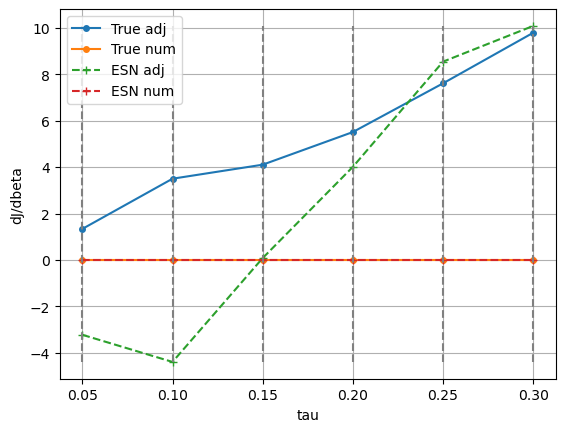

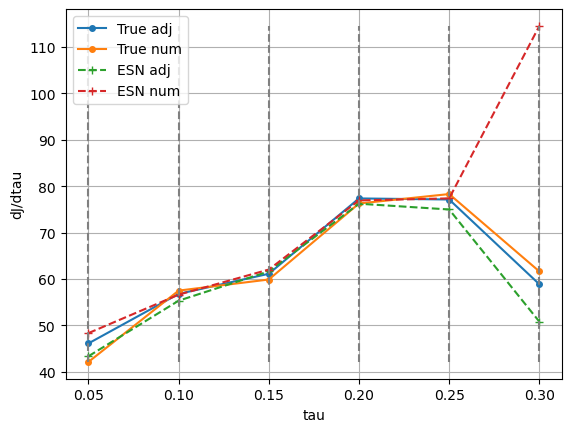

In [54]:
dJ_dp_num_esn_mean = np.mean(dJ_dp_num_esn, axis = 0)
dJ_dp_num_esn_std = np.std(dJ_dp_num_esn, axis = 0)
dJ_dp_adj_esn_mean = np.mean(dJ_dp_adj_esn, axis = 0)
dJ_dp_adj_esn_std = np.std(dJ_dp_adj_esn, axis = 0)
for i in range(2):
    plt.figure()
    plt.plot(my_p_list,dJ_dp_adj_true[:,i],linestyle = '-',marker = 'o', markersize = 4)
    plt.plot(my_p_list,dJ_dp_num_true[:,i],linestyle = '-',marker = 'o', markersize = 4)
    plt.plot(my_p_list,dJ_dp_adj_esn_mean[:,i],linestyle = '--',marker = '+')
    plt.plot(my_p_list,dJ_dp_num_esn_mean[:,i],linestyle = '--',marker = '+')
    # plt.fill_between(my_p_list, dJ_dp_num_esn_mean[:,i]-dJ_dp_num_esn_std[:,i], dJ_dp_num_esn_mean[:,i]+dJ_dp_num_esn_std[:,i],
    #     alpha=0.2, facecolor='tab:orange',antialiased=True)
    ymin = np.min([np.min(dJ_dp_adj_true[:,i]),np.min(dJ_dp_num_true[:,i]),np.min(dJ_dp_adj_esn_mean[:,i]),np.min(dJ_dp_num_esn_mean[:,i])])
    ymax = np.max([np.max(dJ_dp_adj_true[:,i]),np.max(dJ_dp_num_true[:,i]),np.max(dJ_dp_adj_esn_mean[:,i]),np.max(dJ_dp_num_esn_mean[:,i])])
    if param == "beta":
        plt.vlines(np.array(list(set(p_list[:,0]))), 
                   ymin=ymin, ymax=ymax, 
                   color = "grey", linestyles='dashed')
        plt.xlabel("beta")
    elif param == "tau":
        plt.vlines(np.array(list(set(p_list[:,1]))),
                    ymin=ymin, ymax=ymax, 
                    color = "grey", linestyles='dashed')
        plt.xlabel("tau")

    if i == 0:
        plt.ylabel("dJ/dbeta")
    elif i == 1:
        plt.ylabel("dJ/dtau")
    plt.legend(["True adj","True num","ESN adj","ESN num"])
    # plt.ylim([0,10])
    # plt.xlim([0,2])
    plt.grid()

In [9]:
# Calculate jacobian of the reservoir states analytically
x_tau = X_pred_grad[0,:]
x_0 = X_pred_grad[N_tau,:]
x_1 = X_pred_grad[N_tau+1,:]
p_0 = P_grad[0]
# now compare this jacobian to the numerical one
def closed_loop_step(x_tau, x_0, p_0):
    x_0_augmented = np.hstack((x_0, my_ESN.b_out))

    y_tau = np.dot(x_tau, my_ESN.W_out)
    eta_tau = y_tau[0 : my_ESN.N_g]
    velocity_f_tau = Rijke.toVelocity(
        N_g= my_ESN.N_g, eta=eta_tau, x=np.array([my_ESN.x_f])
    )
    y_0 = np.dot(x_0_augmented, my_ESN.W_out)
    y_0 = np.hstack((y_0, velocity_f_tau, velocity_f_tau**2))
    
    x_1 = my_ESN.step(x_0, y_0, p_0)
    return x_1

def closed_loop_step_f(velocity_f_tau, x_0, p_0):
    x_0_augmented = np.hstack((x_0, my_ESN.b_out))
    y_0 = np.dot(x_0_augmented, my_ESN.W_out)
    y_0 = np.hstack((y_0, velocity_f_tau, velocity_f_tau**2))
    
    x_1 = my_ESN.step(x_0, y_0, p_0)
    return x_1
h = 1e-5

# THE BUG IS TO DO WITH THE ALPHA! because alpha = 1.0, the jacs match perfectly
# if alpha not 1.0, then 1-tanh^2(x(i)) no longer equal to 1-x(i+1)^2
my_jac = my_ESN.jac(x_1, x_0)
my_jac_num = np.zeros((my_ESN.N_reservoir,my_ESN.N_reservoir))
for i in range(my_ESN.N_reservoir):
    x_0_left = x_0.copy()
    x_0_left[i] -= h
    x_0_right = x_0.copy()
    x_0_right[i] += h
    x_1_left = closed_loop_step(x_tau,x_0_left,p_0)
    x_1_right = closed_loop_step(x_tau,x_0_right,p_0)
    for j in range(my_ESN.N_reservoir):
        my_jac_num[j,i] = (x_1_right[j]-x_1_left[j])/(2*h)      
print("Difference of analytical vs numerical Jacobian:",np.where(np.abs(my_jac_num-my_jac) > 1e-8))

my_drdp = my_ESN.drdp(x_1, x_0)
p_0_left = p_0-h
p_0_right = p_0+h
x_1_left = closed_loop_step(x_tau,x_0,p_0_left)
x_1_right = closed_loop_step(x_tau,x_0,p_0_right)
my_drdp_num = (x_1_right-x_1_left)/(2*h)
print("Difference of analytical vs numerical dr/dp:",np.where(np.abs(my_drdp_num[:,None]-my_drdp.toarray()) > 1e-8))

y_tau = np.dot(x_tau, my_ESN.W_out)
eta_tau = y_tau[0 : my_ESN.N_g]
u_f_tau_0 = Rijke.toVelocity(
    N_g= my_ESN.N_g, eta=eta_tau, x=np.array([my_ESN.x_f])
)
my_drdu_f_tau = my_ESN.drdu_f_tau(x_1, x_0, u_f_tau_0)
u_f_tau_0_left = u_f_tau_0-h
u_f_tau_0_right = u_f_tau_0+h
x_1_left = closed_loop_step_f(u_f_tau_0_left,x_0,p_0)
x_1_right = closed_loop_step_f(u_f_tau_0_right,x_0,p_0)
my_drdu_f_tau_num = (x_1_right-x_1_left)/(2*h)
print("Difference of analytical vs numerical dr/du_f_tau:",np.where(np.abs(my_drdu_f_tau_num[:,None]-my_drdu_f_tau) > 1e-8))

my_jac_tau = my_ESN.jac_tau(x_1, x_0, u_f_tau_0)
my_jac_tau_num = np.zeros((my_ESN.N_reservoir,my_ESN.N_reservoir))
for i in range(my_ESN.N_reservoir):
    x_tau_left = x_tau.copy()
    x_tau_left[i] -= h
    x_tau_right = x_tau.copy()
    x_tau_right[i] += h
    x_1_left = closed_loop_step(x_tau_left,x_0,p_0)
    x_1_right = closed_loop_step(x_tau_right,x_0,p_0)
    for j in range(my_ESN.N_reservoir):
        my_jac_tau_num[j,i] = (x_1_right[j]-x_1_left[j])/(2*h)      
print("Difference of analytical vs numerical Jacobian tau:",np.where(np.abs(my_jac_tau_num-my_jac_tau) > 1e-8))

Difference of analytical vs numerical Jacobian: (array([], dtype=int64), array([], dtype=int64))
Difference of analytical vs numerical dr/dp: (array([], dtype=int64), array([], dtype=int64))
Difference of analytical vs numerical dr/du_f_tau: (array([], dtype=int64), array([], dtype=int64))
Difference of analytical vs numerical Jacobian tau: (array([], dtype=int64), array([], dtype=int64))


In [10]:
my_drdu_f_tau.shape

(1200, 1)